## icmecat

Makes the interplanetary coronal mass ejection catalog ICMECAT, available at https://helioforecast.space/icmecat.

**latest release: version 2.1, 2021 November 29, updated 2023 January 15**


**Author**: C. Möstl, Austrian Space Weather Office, Geosphere Austria

https://twitter.com/chrisoutofspace / https://mastodon.social/@chrisoutofspace

This notebook is part of the heliocats package https://github.com/cmoestl/heliocats


**doi 10.6084/m9.figshare.6356420**  https://10.6084/m9.figshare.6356420

Install a specific conda environment to run this code, see readme at https://github.com/cmoestl/heliocats

**Adding a new ICME event:** 
- edit the file icmecat/HELCATS_ICMECAT_v21_master.xlsx to add 3 times, the id and spacecraft name
- delete the file for the respective spacecraft under icmecat/indices_icmecat/
- run section 3 in this notebook or script.


**Updating data**
- Solar Orbiter http://soar.esac.esa.int/soar/ 1 min rtn files, then use read_solo.ipynb
- Bepi Colombo manual download, then read_bepi.ipynb
- PSP use cell in this notebook, beware of unfinished file downloads - redo!
- STEREO-Ahead prel. PLASTIC ASCII files, IMPACT as usual (via heliosat), beacon data automatic every day
- Wind automatic everyday, add spike and gap times under hd.remove_wind_spikes_gaps, or use ascii files (cell in this notebook)



Convert this notebook to a script with jupyter nbconvert --to script icmecat.ipynb (automatically done in first cell)

In [1]:
last_update='2023-February-TBD'

In [2]:
import numpy as np
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import  DateFormatter
from datetime import timedelta
import seaborn as sns
import datetime
import astropy
import astropy.constants as const
from sunpy.time import parse_time
import time
import pickle
import sys
import os
import urllib
import json
import importlib
import pandas as pd
import copy
import openpyxl
import h5py
#get heliosat from github or pip https://pypi.org/project/HelioSat/
import heliosat
import heliopy.data.spice as spicedata
import heliopy.spice as spice
import cdflib


import pickle5

import astropy.units as u
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames



from heliocats import plot as hp
importlib.reload(hp) #reload again while debugging

from heliocats import data as hd
importlib.reload(hd) #reload again while debugging

from heliocats import cats as hc
importlib.reload(hc) #reload again while debugging

from heliocats import stats as hs
importlib.reload(hs) #reload again while debugging

#where the in situ data files are located is read 
#from config.py 
import config
importlib.reload(config)
from config import data_path
from config import data_path_ML


########### make directories first time if not there

resdir='results'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

datadir='data'
if os.path.isdir(datadir) == False: os.mkdir(datadir)

indexdir='icmecat/indices_icmecat' 
if os.path.isdir(indexdir) == False: os.mkdir(indexdir) 

catdir='icmecat'
if os.path.isdir(catdir) == False: os.mkdir(catdir)

icplotsdir='icmecat/plots_icmecat/' 
if os.path.isdir(icplotsdir) == False: os.mkdir(icplotsdir) 

#Convert this notebook to a script with jupyter nbconvert --to script icmecat.ipynb
os.system('jupyter nbconvert --to script icmecat.ipynb')    

import warnings
warnings.filterwarnings('ignore')
print('done')

print(heliosat.__version__)

/nas/helio/heliofc/miniconda3/envs/helio2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[NbConvertApp] Converting notebook icmecat.ipynb to script


done
0.6.2


[NbConvertApp] Writing 63788 bytes to icmecat.py


## (0) process new in situ data into similar format

### for Bepi Colombo, got to read_bepi.ipynb

### for Solar Orbiter, got to read_solo.ipynb



### Parker Solar Probe

#### file downloads

In [ ]:
################### FIELDS
#generate datestrings for filenames
time1=[]
tstart1=datetime.datetime(2022, 3, 31)
tend1=datetime.datetime(2023, 1, 1)
while tstart1 < tend1:
    time1.append(tstart1)  
    tstart1 += timedelta(days=1) 


#version 1 until 2020 July 31
#version 2 from 2020 Oct 21
    
os.chdir('/nas/helio/data/heliosat/data/psp_fields_l2')
#download each file
for i in np.arange(0,len(time1)):    
    time1str=time1[i].strftime('%Y%m%d')
    time1year=time1[i].strftime('%Y')  
    os.system('wget -nc https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min/'+time1year+'/psp_fld_l2_mag_rtn_1min_'+time1str+'_v02.cdf')
    
os.chdir('/home/heliofc/pycode/heliocats')

############# SWEAP

time1=[]
tstart1=datetime.datetime(2022, 7, 31)
tend1=datetime.datetime(2023, 1, 1)
while tstart1 < tend1:
    time1.append(tstart1)  
    tstart1 += timedelta(days=1) 

os.chdir('/nas/helio/data/heliosat/data/psp_spc_l3')

for i in np.arange(0,len(time1)):    
    time1str=time1[i].strftime('%Y%m%d')
    time1year=time1[i].strftime('%Y')    
    os.system('wget -nc https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/'+time1year+'/psp_swp_spc_l3i_'+time1str+'_v02.cdf')
      

os.chdir('/home/heliofc/pycode/heliocats')

File ‘psp_fld_l2_mag_rtn_1min_20220331_v02.cdf’ already there; not retrieving.

File ‘psp_fld_l2_mag_rtn_1min_20220401_v02.cdf’ already there; not retrieving.

File ‘psp_fld_l2_mag_rtn_1min_20220402_v02.cdf’ already there; not retrieving.

File ‘psp_fld_l2_mag_rtn_1min_20220403_v02.cdf’ already there; not retrieving.

File ‘psp_fld_l2_mag_rtn_1min_20220404_v02.cdf’ already there; not retrieving.

File ‘psp_fld_l2_mag_rtn_1min_20220405_v02.cdf’ already there; not retrieving.

File ‘psp_fld_l2_mag_rtn_1min_20220406_v02.cdf’ already there; not retrieving.

File ‘psp_fld_l2_mag_rtn_1min_20220407_v02.cdf’ already there; not retrieving.

File ‘psp_fld_l2_mag_rtn_1min_20220408_v02.cdf’ already there; not retrieving.

--2023-01-16 14:32:27--  https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min/2022/psp_fld_l2_mag_rtn_1min_20220409_v02.cdf
Connecting to 193.171.196.7:3128... connected.
Proxy request sent, awaiting response... 404 Not Found
2023-01-16 14:32:28 ERROR 404: Not Found.

F

#### process to pickle file

In [10]:
from heliocats import data as hd
importlib.reload(hd) #reload again while debugging

#print('save PSP data') #from heliosat, converted to SCEQ similar to STEREO-A/B
#+**change end date in function
filepsp='psp_2022_rtn_new_jan2023.p'
hd.save_psp_data_mag_only(data_path,filepsp, sceq=False)   
print('rtn done')

filepsp='psp_2022_sceq_new_jan2023.p'
hd.save_psp_data_mag_only(data_path,filepsp, sceq=True)   
print('sceq done')

#filepsp='psp_2022_sceq_new_nov2022.p'
#hd.save_psp_data(data_path,filepsp, sceq=True)   
#print('sceq done')


filepsp='psp_2022_rtn_new_jan2023_magplasma.p'
hd.save_psp_data(data_path,filepsp, sceq=False)   
print('sceq done')


filepsp='psp_2022_sceq_new_jan2023_magplasma.p'
hd.save_psp_data(data_path,filepsp, sceq=True)   
print('sceq done')


#print('load PSP data RTN') 
#
import warnings
warnings.filterwarnings('ignore')

filepsp='psp_2022_rtn_new_jan2023.p'
[psp,hpsp]=pickle.load(open(data_path+filepsp, "rb" ) ) 
    


save PSP data mag only
start PSP


failed to fetch url "https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min/2022/psp_fld_l2_mag_rtn_1min_20220104_v02.cdf" (404)
NoneType: None
failed to fetch url "https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min/2022/psp_fld_l2_mag_rtn_1min_20220409_v02.cdf" (404)
NoneType: None
failed to fetch url "https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min/2022/psp_fld_l2_mag_rtn_1min_20220417_v02.cdf" (404)
NoneType: None
failed to fetch url "https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min/2022/psp_fld_l2_mag_rtn_1min_20220104_v01.cdf" (404)
NoneType: None
failed to fetch data file "psp_fld_l2_mag_rtn_1min_20220104_{VER}.cdf" (versions: ['v02', 'v01'])
NoneType: None
failed to fetch url "https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min/2022/psp_fld_l2_mag_rtn_1min_20220409_v01.cdf" (404)
NoneType: None
failed to fetch url "https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min/2022/psp_fld_l2_mag_rtn_1min_20220417_v01.c

download complete
start nan or interpolate
field
end nan or interpolate
position start
PSP pos
position end
done get psp

rtn done
save PSP data mag only
start PSP


failed to fetch url "https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min/2022/psp_fld_l2_mag_rtn_1min_20220104_v02.cdf" (404)
NoneType: None
failed to fetch url "https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min/2022/psp_fld_l2_mag_rtn_1min_20220417_v02.cdf" (404)
NoneType: None
failed to fetch url "https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min/2022/psp_fld_l2_mag_rtn_1min_20220409_v02.cdf" (404)
NoneType: None
failed to fetch url "https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min/2022/psp_fld_l2_mag_rtn_1min_20220104_v01.cdf" (404)
NoneType: None
failed to fetch data file "psp_fld_l2_mag_rtn_1min_20220104_{VER}.cdf" (versions: ['v02', 'v01'])
NoneType: None
failed to fetch url "https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min/2022/psp_fld_l2_mag_rtn_1min_20220417_v01.cdf" (404)
NoneType: None
failed to fetch data file "psp_fld_l2_mag_rtn_1min_20220417_{VER}.cdf" (versions: ['v02', 'v01'])
NoneType: None
failed to fetc

download complete
start nan or interpolate
field
end nan or interpolate
position start
PSP pos
position end
done get psp

RTN to SCEQ
sceq done
save PSP data
start PSP


failed to fetch url "https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min/2019/psp_fld_l2_mag_rtn_1min_20190105_v02.cdf" (404)
NoneType: None
failed to fetch url "https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min/2018/psp_fld_l2_mag_rtn_1min_20181223_v02.cdf" (404)
NoneType: None
failed to fetch url "https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min/2019/psp_fld_l2_mag_rtn_1min_20190111_v02.cdf" (404)
NoneType: None
failed to fetch url "https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min/2018/psp_fld_l2_mag_rtn_1min_20181230_v02.cdf" (404)
NoneType: None
failed to fetch url "https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min/2019/psp_fld_l2_mag_rtn_1min_20190106_v02.cdf" (404)
NoneType: None
failed to fetch url "https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min/2018/psp_fld_l2_mag_rtn_1min_20181226_v02.cdf" (404)
NoneType: None
failed to fetch url "https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min/2018

KeyError: 'data_key "psp_spc_l3" not found'

#### plot PSP data

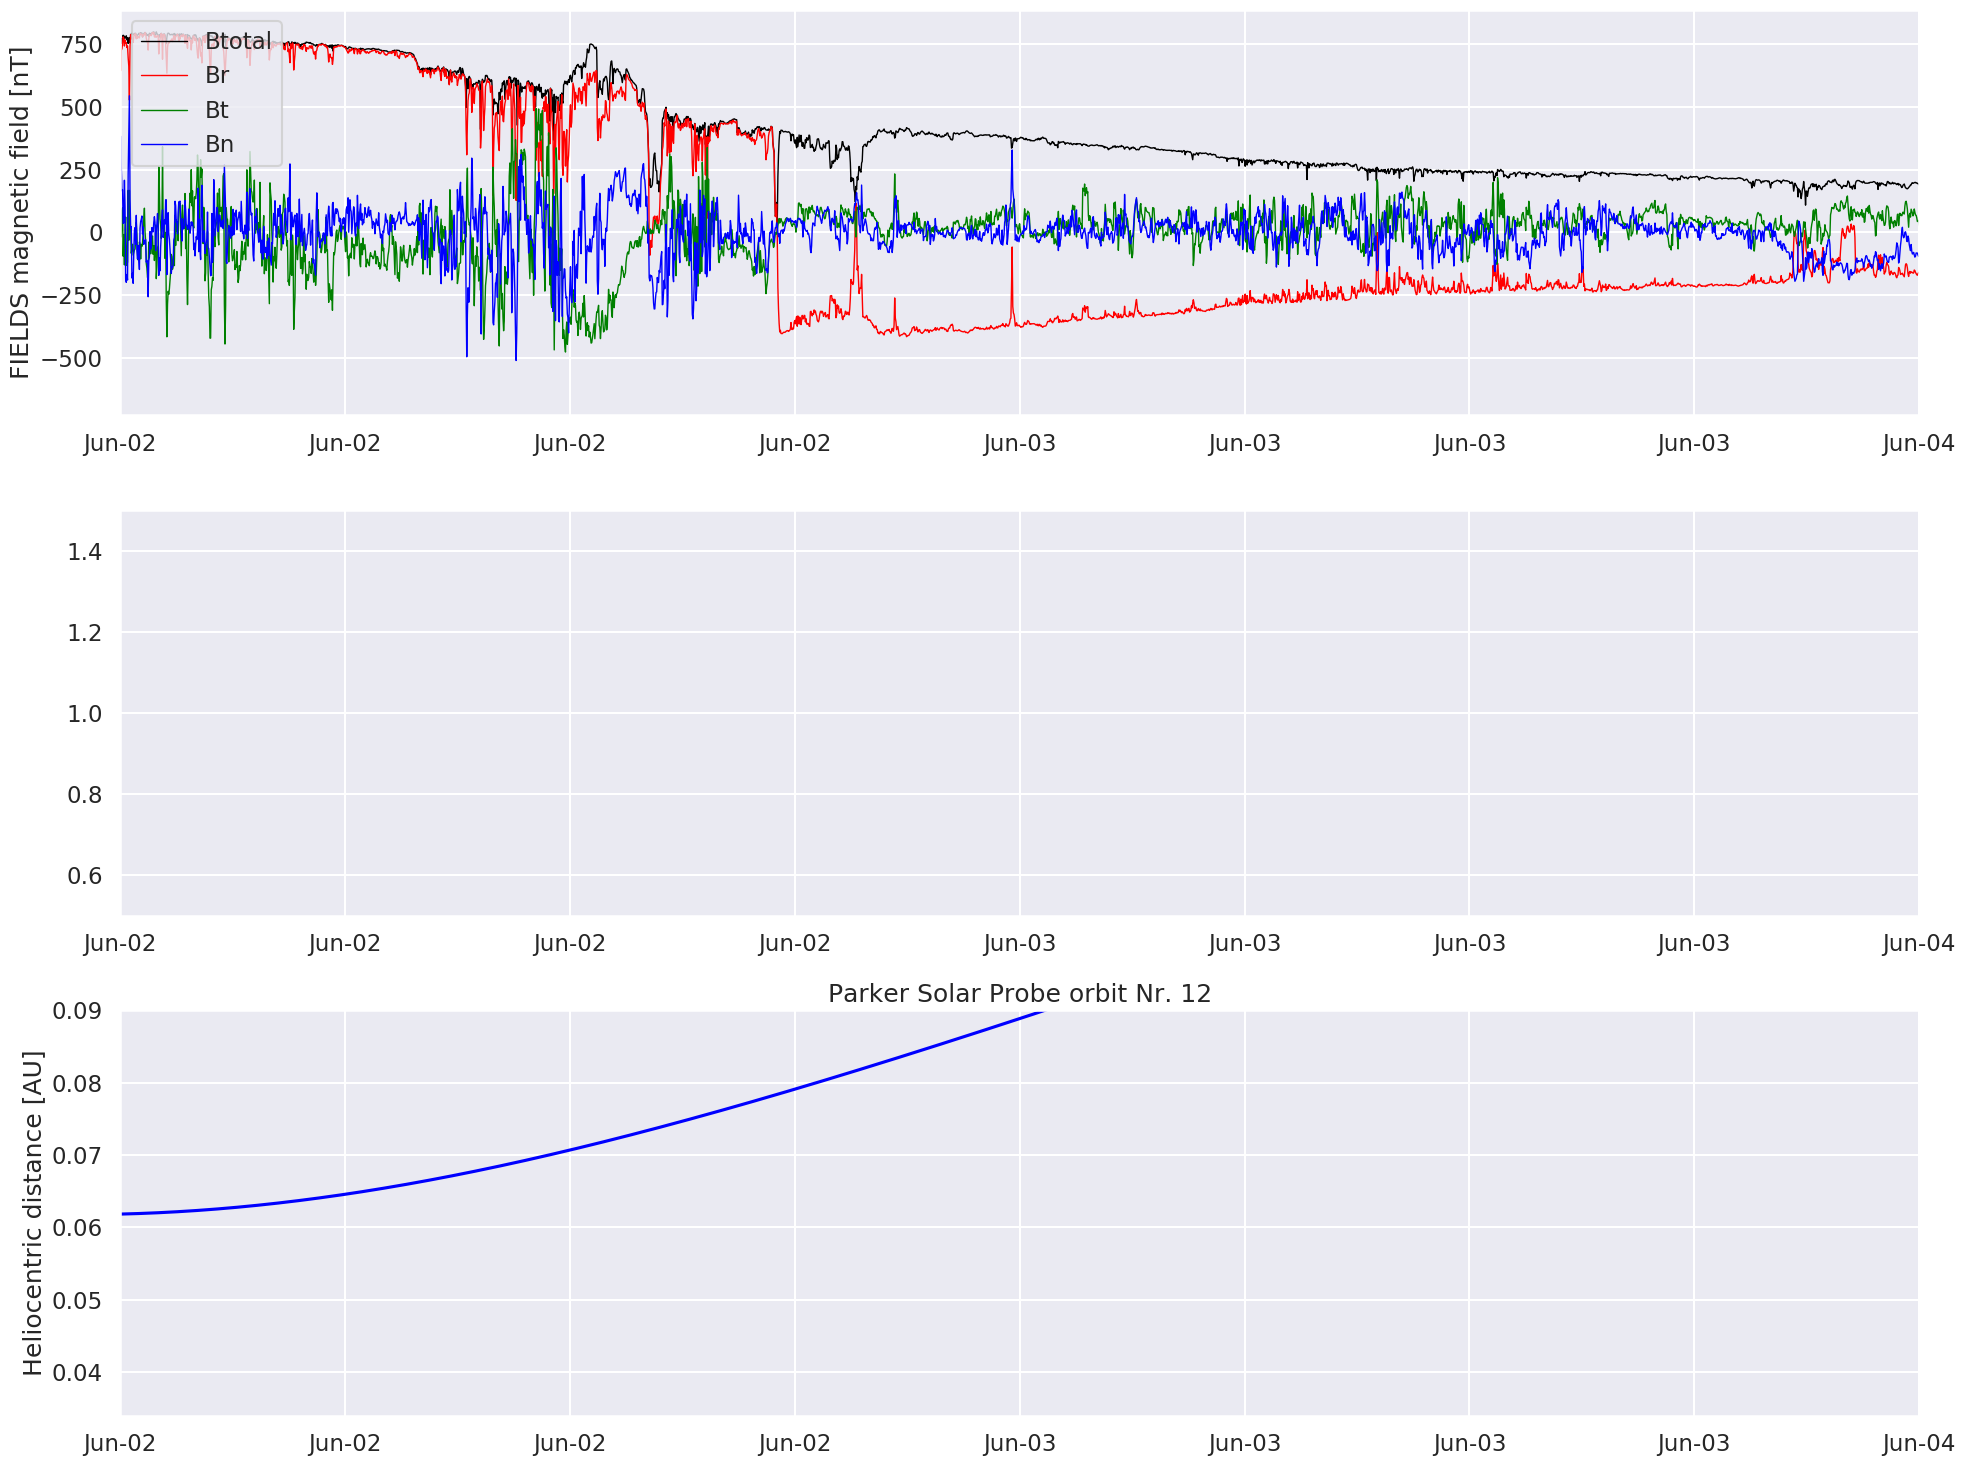

In [13]:



#print('load PSP data RTN') 
#
import warnings
warnings.filterwarnings('ignore')

filepsp='psp_2022_rtn_new_jan2023.p'
[psp,hpsp]=pickle.load(open(data_path+filepsp, "rb" ) ) 
    

#orbit 10
#start=datetime.datetime(2021,11,15)
#end=datetime.datetime(2021,11,25)

start=datetime.datetime(2022,6,2)
end=datetime.datetime(2022,6,4)



################ plot new psp data for checking
sns.set_context("talk")     
sns.set_style('darkgrid')

fig=plt.figure(3,figsize=(20,15),dpi=100)

ax1=plt.subplot(311)

#  #ax1.plot(psp.time,psp.bt,'-k',lw=0.5,label='Btotal')
# #ax1.plot(psp.time,psp.bx,'-r',lw=0.2,label='Br')
# #ax1.plot(psp.time,psp.by,'-g',lw=0.2,label='Bt')
# #ax1.plot(psp.time,psp.bz,'-b',lw=0.2,label='Bn')

ax1.plot(psp.time,psp.bt,'-k',lw=1,label='Btotal')
ax1.plot(psp.time,psp.bx,'-r',lw=1,label='Br')
ax1.plot(psp.time,psp.by,'-g',lw=1,label='Bt')
ax1.plot(psp.time,psp.bz,'-b',lw=1,label='Bn')
ax1.set_xlim(start,end)
ax1.set_ylabel('FIELDS magnetic field [nT]')
ax1.legend(loc=2)
#ax1.set_ylim(-20,20)



from astropy.constants import mu0,m_p
va=(psp.bt*1e-9)/np.sqrt(mu0.value*(psp.np*1e6)*m_p.value)*1e-3

ax2=plt.subplot(312,sharex=ax1)
ax2.plot(psp.time,psp.vt/va,'--',lw=1,label='M_A')
ax2.set_ylim(0.5,1.5)


ax3=plt.subplot(313,sharex=ax1)
ax3.plot(psp.time,psp.r,'-b')
ax3.set_ylim(0.034,0.09)

ax3.set_ylabel('Heliocentric distance [AU]')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

plt.title('Parker Solar Probe orbit Nr. 12')
plt.tight_layout()

# plt.savefig('results/parker_orbit_venus.png',dpi=200)
plt.savefig('results/parker_orbit12_zoom.png')
plt.savefig('results/parker_orbit12_zoom.pdf')



## Other spacecraft

In [5]:
############################# make Ulysses files
#hd.save_ulysses_data(data_path)

############################## make STEREO-B data files
# STEREO-B

# filestb_all='stereob_2007_2014_rtn.p'
# hd.save_all_stereob_science_data(data_path, filestb_all,sceq=False)
# [sb1,hsb1]=pickle.load(open(data_path+filestb_all, "rb" ) )  

# filestb_all='stereob_2007_2014_sceq.p'
# hd.save_all_stereob_science_data(data_path, filestb_all,sceq=True)
# [sb2,hsb2]=pickle.load(open(data_path+filestb_all, "rb" ) )  

# plt.plot(stb.time,stb.by,'-g',linewidth=5)
# plt.plot(sb2.time,sb2.by,'-k')
# plt.plot(sb1.time,sb1.by,'-b')
# #plt.plot(stb.time,stb.lat,'-r')

# plt.xlim(parse_time('2007-08-15').plot_date,parse_time('2007-08-15 12:00').plot_date)
# plt.ylim(-5,4)



############################## make Wind data files



# ################################# Wind

# filewin="wind_2018_2019_gse.p" 
# start=datetime.datetime(2018, 1, 1)
# end=datetime.datetime(2020, 1, 1)
# hd.save_wind_data(data_path,filewin,start,end,heeq=False)

# filewin="wind_2018_2019_heeq.p" 
# start=datetime.datetime(2018, 1, 1)
# #end=datetime.datetime(2019, 12, 31)
# end=datetime.datetime.utcnow()
# hd.save_wind_data(data_path,filewin,start,end,heeq=True)

# filewin1="wind_2007_2018_heeq_helcats.p" 
# [win1,hwin1]=pickle.load(open(data_path+filewin1, "rb" ) )  
# filewin2="wind_2018_2019_heeq.p" 
# [win2,hwin2]=pickle.load(open(data_path+filewin2, "rb" ) )  
# filewin3="wind_2018_2019_gse.p" 
# [win3,hwin3]=pickle.load(open(data_path+filewin3, "rb" ) )  



#filewin="wind_2018_2019_gse.p" 
#for updating data
#start=datetime.datetime(2018, 1, 1)
#end=datetime.datetime(2020, 1, 1)
#hd.save_wind_data(data_path,filewin,start,end,heeq=False)


########## check GSE to HEEQ conversion

#save=1

#if save > 0:

#    filewin="wind_2018_2020_sept_heeq.p" 
#    start=datetime.datetime(2018, 1 , 1)
#    end=datetime.datetime(2020, 8, 31)

    #filewin="wind_heeq_test.p" 
    #start=datetime.datetime(2019, 8, 1)
    #end=datetime.datetime(2019, 10, 1)


    #end=datetime.datetime.utcnow()
#    hd.save_wind_data(data_path,filewin,start,end,heeq=True)

    
    #filewin="wind_2018_2020_sept_gse.p" 
    #start=datetime.datetime(2018, 1, 1)
    #end=datetime.datetime(2020, 7, 31)

    #filewin="wind_gse_test.p" 
    #start=datetime.datetime(2019, 8, 1)
    #end=datetime.datetime(2019, 10, 1)


    #end=datetime.datetime.utcnow()
    #hd.save_wind_data(data_path,filewin,start,end,heeq=False)



#filewin="wind_2018_now_gse.p" 
#[wing,hwing]=pickle.load(open(data_path+filewin, "rb" ) )  

#filewin="wind_2018_2020_sept_heeq.p" 
#[winh,hwinh]=pickle.load(open(data_path+filewin, "rb" ) )  

    
#plt.plot(wing.time,wing.bx,'-k',label='gse')
#plt.plot(winh.time,winh.bx,'-g',label='heeq')
#plt.plot(sc.time,ang[:,1],'-r',label='theta')
#plt.plot(sc.time,ang[:,2],'-b',label='lambda - omega mod 360')

#plt.legend()






########################## SAVE MSL rad data into recarray as pickle
#hd.save_msl_rad()




############################# make STEREO-A science data files

#filesta_all='stereoa_2007_2019_rtn.p'
#hd.save_all_stereoa_science_data(data_path, filesta_all,sceq=False)
#[sa1,hsa1]=pickle.load(open(data_path+filesta_all, "rb" ) )  

#filesta_all='stereoa_2007_2019_sceq.p'
#hd.save_all_stereoa_science_data(data_path, filesta_all,sceq=True)
#[sa2,hsa2]=pickle.load(open(data_path+filesta_all, "rb" ) )  




########################### STEREO-A science data after December 2019, ascii plastic files
# start=datetime.datetime(2020, 1,1)
# end=datetime.datetime(2020, 5, 1)
# #filesta="stereoa_2020_april_rtn.p" 
# filesta="stereoa_2020_april_sceq.p" 
# hd.save_stereoa_science_data(data_path,filesta,start, end,sceq=True)


# start=datetime.datetime(2020, 5,1)
# end=datetime.datetime(2020, 8, 1)
# #filesta="stereoa_2020_may_july_rtn.p" 
# filesta="stereoa_2020_may_july_sceq.p" 
# hd.save_stereoa_science_data(data_path,filesta,start, end,sceq=True)


#delete 2020 IMPACT March 11, April 17, May 18, July9 -corrupt cdf

#hd.save_stereoa_science_data(data_path,filesta,start, end,sceq=False)
#hd.save_stereoa_science_data_new(data_path,filesta,start, end,sceq=True)

#[sta2,hsta2]=pickle.load(open(data_path+filesta, "rb"))  

#plt.figure(100,dpi=300)
#plt.plot(sta2.time,sta2.bt)
#plt.plot(sta2.time,sta2.bx)
#plt.plot(sta2.time,sta2.by)
#plt.plot(sta2.time,sta2.bz)


#plt.figure(101,dpi=300)
#plt.plot(sta2.time,sta2.vt)

########################## stitch together all science data files

#filesta="stereoa_2007_2020_rtn.p"
#hd.save_stereoa_science_data_merge_rtn(data_path,filesta)

#filesta="stereoa_2007_2020_sceq.p"
#hd.save_stereoa_science_data_merge_sceq(data_path,filesta)

# sta=pickle.load(open(data_path+filesta, "rb" ) )  

# plt.figure(101,dpi=300)
# plt.plot(sta.time,sta.bx)
# plt.plot(sta.time,sta.by)
# plt.plot(sta.time,sta.bz)

# plt.figure(102,dpi=300)
# plt.plot(sta.time,sta.vt)




################################### STEREO-A beacon
#filesta="stereoa_2020_now_sceq_beacon_test.p" 

# start=datetime.datetime(2020, 8, 1)
# #end=datetime.datetime(2020, 8, 15)
# end=datetime.datetime.utcnow()

# filesta="stereoa_2020_august_november_rtn_beacon.p" 
# hd.save_stereoa_beacon_data(data_path,filesta,start,end,sceq=False)

# filesta="stereoa_2020_august_november_sceq_beacon.p" 
# hd.save_stereoa_beacon_data(data_path,filesta,start,end,sceq=True)


# [sta,hsta]=pickle.load(open(data_path+filesta, "rb" ) ) 


# plt.figure(1,dpi=300)
# plt.plot(sta.time,sta.bt)
# plt.plot(sta.time,sta.bx)
# plt.plot(sta.time,sta.by)
# plt.plot(sta.time,sta.bz)


# plt.figure(2,dpi=300)
# plt.plot(sta.time,sta.vt)
# print('done')

### process Wind data since 1995

In [ ]:
%%time 

from heliocats import data as hd
importlib.reload(hd) #reload again while debugging

#download ascii files
#hd.wind_download_ascii()

start=datetime.datetime(1995,1,1)
end=datetime.datetime(2022,5,30)


#end=datetime.datetime.utcnow() 
path='/nas/helio/data/insitu_python/'


file='wind_1995_2022_heeq.p'
hd.save_wind_data_ascii(path,file,start,end,coord='HEEQ')

file='wind_1995_2022_gse.p'
hd.save_wind_data_ascii(path,file,start,end,coord='GSE')


file='wind_1995_2022_gsm.p'
hd.save_wind_data_ascii(path,file,start,end,coord='GSM')

#filewin="wind_1995_2021_gsm.p" 
#[win,hwin]=pickle.load(open(data_path+filewin, "rb" ) )  



#GSE GSM comparison

#win=win[3000000:7056000]

#filewin="wind_1995_2021_heeq.p" 
#[winh,hwin]=pickle.load(open(data_path+filewin, "rb" ) )  

#winh=winh[3000000:7056000]


#np.nanstd(winh.bz-win.bz)
#np.nanmean(winh.bz-win.bz)




## (1) load data 

In [3]:
#made with HelioSat and heliocats.data

load_data=1


if load_data > 0:
            
    print('load Ulysses RTN') #made with heliocats.data.save_ulysses_data
    fileuly='ulysses_1990_2009_rtn.p'
    [uly,huly]=pickle.load(open(data_path+fileuly, "rb" ) )     
 
    print('load VEX data (Venus magnetosphere removed) SCEQ') #legacy from HELCATS project in SCEQ, removed magnetosphere
    filevex='vex_2007_2014_sceq_removed.p'
    [vex,hvex]=pickle.load(open(data_path+filevex, 'rb' ) )

    print('load MESSENGER data (Mercury magnetosphere removed) SCEQ') #legacy from HELCATS project in SCEQ, removed magnetosphere
    filemes='messenger_2007_2015_sceq_removed.p'
    [mes,hmes]=pickle.load(open(data_path+filemes, 'rb' ) )
 
    print('load STEREO-B data SCEQ') #yearly magplasma files from stereo science center, conversion to SCEQ 
    filestb='stereob_2007_2014_sceq.p'
    [stb,hstb]=pickle.load(open(data_path+filestb, "rb" ) )      
    
    #use pickle5 to read
    #print('load Juno data ') #Emma Davies https://figshare.com/articles/dataset/Juno_Cruise_Phase_Magnetometer_and_Position_Data/19517257
    #juno_df = pd.read_pickle(data_path+'juno_2011_2016_rtn.pkl') 

    

    ########### CURRENT ACTIVE SPACECRAFT    


    ############### convert MAVEN from Cyril's MAT file to pickle
    
    #from heliocats import data as hd
    #importlib.reload(hd) #reload again while debugging
    
    #file_input=data_path+'input/Data-MAVEN-MAG_SolarWind_102014-012021.mat'        
    #filename=data_path+'maven_2014_2021_removed_no_plasma.p'
    #hd.convert_MAVEN_mat_removed(file_input,filename)

    #filemav=data_path+'maven_2014_2021_removed_no_plasma.p'   
    #filename=data_path+'maven_2014_2021_removed_smoothed_no_plasma.p'   
    #hd.MAVEN_smooth_orbit(filemav,filename)
    
    
    
    
    print('load MAVEN data MSO') 
    #filemav='maven_2014_2018.p'
    #[mav,hmav]=pickle.load(open(filemav, 'rb' ) )

    #combined plasma and mag
    filemav='maven_2014_2018_removed.p'
    [mavr,hmavr]=pickle.load(open(data_path+filemav, 'rb' ) )    
    filemav='maven_2014_2018_removed_smoothed.p'
    [mav,hmav]=pickle.load(open(data_path+filemav, 'rb' ) )

    #only mag
    filemav='maven_2014_2021_removed_no_plasma.p'
    [mav2,hmav2]=pickle.load(open(data_path+filemav, 'rb' ) )    

    filemav='maven_2014_2021_removed_smoothed_no_plasma.p'
    [mavr2,hmavr2]=pickle.load(open(data_path+filemav, 'rb' ) )    


    
    #removed magnetosphere by C. Simon Wedlund, 1 data point per orbit, MSO
    #filemav='maven_2014_2021_removed_smoothed.p'
    #[mav,hmav]=pickle.load(open(data_path+filemav, 'rb' ) )
    
        
    #use hd.save_msl_rad() first to convert data doseE_sol_filter_2019.dat to pickle file
    print('load MSL RAD')
    #MSL RAD
    rad=hd.load_msl_rad()#, rad.time,rad.dose_sol
    
    ##############################################
    #data to 2021 Aug 2
    print('load Bepi Colombo SCEQ')
    filebepi='bepi_2019_2021_sceq.p'
    bepi1=pickle.load(open(data_path+filebepi, "rb" ) )  
    
    #data from 2021 Aug 3

    filebepi2='bepi_2021_2022_ib_sceq.p'
    bepi2=pickle.load(open(data_path+filebepi2, "rb" ) )   

    
    #make array
    bepi=np.zeros(np.size(bepi1.time)+np.size(bepi2.time),dtype=[('time',object),('bx', float),('by', float),\
                ('bz', float),('bt', float),\
                ('x', float),('y', float),('z', float),\
                ('r', float),('lat', float),('lon', float)])   

    #convert to recarray
    bepi = bepi.view(np.recarray)  
    bepi.time=np.hstack((bepi1.time,bepi2.time))
    bepi.bx=np.hstack((bepi1.bx,bepi2.bx))
    bepi.by=np.hstack((bepi1.by,bepi2.by))
    bepi.bz=np.hstack((bepi1.bz,bepi2.bz))
    bepi.bt=np.hstack((bepi1.bt,bepi2.bt))
    bepi.x=np.hstack((bepi1.x,bepi2.x))
    bepi.y=np.hstack((bepi1.y,bepi2.y))
    bepi.z=np.hstack((bepi1.z,bepi2.z))
    bepi.r=np.hstack((bepi1.r,bepi2.r))
    bepi.lon=np.hstack((bepi1.lon,bepi2.lon))
    bepi.lat=np.hstack((bepi1.lat,bepi2.lat))
    print('Bepi Merging done')

  
    
    
    
   
    ##############################################
    print('load Solar Orbiter SCEQ')
    filesolo='solo_2020_april_2022_june_sceq.p'
    solo=pickle.load(open(data_path+filesolo, "rb" ) )    
    
    #set all plasma data to NaN
    solo.vt=np.nan
    solo.np=np.nan
    solo.tp=np.nan


    ##############################################
    print('load PSP data SCEQ') #from heliosat, converted to SCEQ similar to STEREO-A/B
    filepsp='psp_2018_2022_sceq.p'
    [psp1,hpsp]=pickle.load(open(data_path+filepsp, "rb" ) ) 
    
    #add file with mag only for 2022, plasma needs to be added in heliosat
    #psp_2022_sceq_new_nov2022.p
    
    filepsp2='psp_2022_sceq_new_nov2022.p'
    [psp2,hpsp2]=pickle.load(open(data_path+filepsp2, "rb" ) )   

  
    psp=np.zeros(np.size(psp1.time)+np.size(psp2.time),dtype=[('time',object),('bx', float),('by', float),\
                ('bz', float),('bt', float),('vt', float),('np', float),('tp', float),\
                ('x', float),('y', float),('z', float),\
                ('r', float),('lat', float),('lon', float)])   

    #convert to recarray
    psp = psp.view(np.recarray)  
    psp.time=np.hstack((psp1.time,psp2.time))
    psp.bx=np.hstack((psp1.bx,psp2.bx))
    psp.by=np.hstack((psp1.by,psp2.by))
    psp.bz=np.hstack((psp1.bz,psp2.bz))
    psp.bt=np.hstack((psp1.bt,psp2.bt))
    psp.vt=np.hstack((psp1.vt,psp2.vt))
    psp.np=np.hstack((psp1.np,psp2.np))
    psp.tp=np.hstack((psp1.tp,psp2.tp))
    psp.x=np.hstack((psp1.x,psp2.x))
    psp.y=np.hstack((psp1.y,psp2.y))
    psp.z=np.hstack((psp1.z,psp2.z))
    psp.r=np.hstack((psp1.r,psp2.r))
    psp.lon=np.hstack((psp1.lon,psp2.lon))
    psp.lat=np.hstack((psp1.lat,psp2.lat))
    print('psp Merging done')

    
    
    
    
    
    ########### STA
    
    print('load and merge STEREO-A data SCEQ') #yearly magplasma files from stereo science center, conversion to SCEQ 
    filesta1='stereoa_2007_2020_sceq.p'
    sta1=pickle.load(open(data_path+filesta1, "rb" ) )  
    
    #beacon data
    #filesta2="stereoa_2019_2020_sceq_beacon.p"
    #filesta2='stereoa_2019_2020_sept_sceq_beacon.p'
    #filesta2='stereoa_2019_now_sceq_beacon.p'
    #filesta2="stereoa_2020_august_november_sceq_beacon.p" 
    filesta2='stereoa_2020_now_sceq_beacon.p'
    
    [sta2,hsta2]=pickle.load(open(data_path+filesta2, "rb" ) )  
    #cutoff with end of science data
    sta2=sta2[np.where(sta2.time >= parse_time('2020-Aug-01 00:00').datetime)[0]]

    #make array
    sta=np.zeros(np.size(sta1.time)+np.size(sta2.time),dtype=[('time',object),('bx', float),('by', float),\
                ('bz', float),('bt', float),('vt', float),('np', float),('tp', float),\
                ('x', float),('y', float),('z', float),\
                ('r', float),('lat', float),('lon', float)])   

    #convert to recarray
    sta = sta.view(np.recarray)  
    sta.time=np.hstack((sta1.time,sta2.time))
    sta.bx=np.hstack((sta1.bx,sta2.bx))
    sta.by=np.hstack((sta1.by,sta2.by))
    sta.bz=np.hstack((sta1.bz,sta2.bz))
    sta.bt=np.hstack((sta1.bt,sta2.bt))
    sta.vt=np.hstack((sta1.vt,sta2.vt))
    sta.np=np.hstack((sta1.np,sta2.np))
    sta.tp=np.hstack((sta1.tp,sta2.tp))
    sta.x=np.hstack((sta1.x,sta2.x))
    sta.y=np.hstack((sta1.y,sta2.y))
    sta.z=np.hstack((sta1.z,sta2.z))
    sta.r=np.hstack((sta1.r,sta2.r))
    sta.lon=np.hstack((sta1.lon,sta2.lon))
    sta.lat=np.hstack((sta1.lat,sta2.lat))
    print('STA Merging done')

   

    #### Wind

    filewin="wind_1995_2021_heeq.p" 
    [win1,hwin1]=pickle.load(open(data_path+filewin, "rb" ) )  

    #add new data from 2021 October 31

    filewin2="wind_2018_now_heeq.p" 
    [win2,hwin2]=pickle.load(open(data_path+filewin2, "rb" ) )  

    #function for spike removal, see list with times in that function
    win2=hd.remove_wind_spikes_gaps(win2)

    #merge Wind old and new data 
    win1=win1[np.where(win1.time < parse_time('2021-Oct-31 00:00').datetime)[0]]
    #make array
    win=np.zeros(np.size(win1.time)+np.size(win2.time),dtype=[('time',object),('bx', float),('by', float),\
                ('bz', float),('bt', float),('vt', float),('np', float),('tp', float),\
                ('x', float),('y', float),('z', float),\
                ('r', float),('lat', float),('lon', float)])   

    #convert to recarray
    win = win.view(np.recarray)  
    win.time=np.hstack((win1.time,win2.time))
    win.bx=np.hstack((win1.bx,win2.bx))
    win.by=np.hstack((win1.by,win2.by))
    win.bz=np.hstack((win1.bz,win2.bz))
    win.bt=np.hstack((win1.bt,win2.bt))
    win.vt=np.hstack((win1.vt,win2.vt))
    win.np=np.hstack((win1.np,win2.np))
    win.tp=np.hstack((win1.tp,win2.tp))
    win.x=np.hstack((win1.x,win2.x))
    win.y=np.hstack((win1.y,win2.y))
    win.z=np.hstack((win1.z,win2.z))
    win.r=np.hstack((win1.r,win2.r))
    win.lon=np.hstack((win1.lon,win2.lon))
    win.lat=np.hstack((win1.lat,win2.lat))

    print('Wind merging done')
            

    
#wind data from 1995    
    

    
#LOAD HELCATS catalogs

#HIGEOCAT
higeocat=hc.load_higeocat_vot('data/HCME_WP3_V06.vot')
higeocat_time=parse_time(higeocat['Date']).datetime    

#load arrcat as pandas dataframe
file='arrcat/HELCATS_ARRCAT_v20_pandas.p'
[ac_pandas,h]=pickle.load( open(file, 'rb')) 
    
              
print()
    
print()       
print('time ranges of the in situ data: ')    
print()
print('active spacecraft:')

print('Solar Orbiter        ',str(solo.time[0])[0:10],str(solo.time[-1])[0:10])
print('Bepi Colombo         ',str(bepi.time[0])[0:10],str(bepi.time[-1])[0:10])
print('Parker Solar Probe   ',str(psp.time[0])[0:10],str(psp.time[-1])[0:10])
print('Wind                 ',str(win.time[0])[0:10],str(win.time[-1])[0:10])
print('STEREO-A             ',str(sta.time[0])[0:10],str(sta.time[-1])[0:10])
print('MAVEN                ',str(mav.time[0])[0:10],str(mav.time[-1])[0:10])
print('MSL/RAD              ',str(rad.time[0])[0:10],str(rad.time[-1])[0:10])
print()
print('missions finished:')
print('VEX                  ',str(vex.time[0])[0:10],str(vex.time[-1])[0:10])
print('MESSENGER            ',str(mes.time[0])[0:10],str(mes.time[-1])[0:10])
print('STEREO-B             ',str(stb.time[0])[0:10],str(stb.time[-1])[0:10])
print('Ulysses              ',str(uly.time[0])[0:10],str(uly.time[-1])[0:10])
#print('Juno cruise phase    ',str(uly.time[0])[0:10],str(uly.time[-1])[0:10])


print()
print('catalogs:')
print()
print('HELCATS HIGeoCAT     ',str(higeocat_time[0])[0:10],str(higeocat_time[-1])[0:10])
print('HELCATS ARRCAT       ',np.sort(ac_pandas.sse_launch_time)[0][0:10],np.sort(ac_pandas.sse_launch_time)[-1][0:10])



print('done')

load Ulysses RTN
load VEX data (Venus magnetosphere removed) SCEQ
load MESSENGER data (Mercury magnetosphere removed) SCEQ
load STEREO-B data SCEQ
load MAVEN data MSO
load MSL RAD
load Bepi Colombo SCEQ
Bepi Merging done
load Solar Orbiter SCEQ
load PSP data SCEQ
psp Merging done
load and merge STEREO-A data SCEQ
STA Merging done
Wind merging done


time ranges of the in situ data: 

active spacecraft:
Solar Orbiter         2020-04-18 2022-06-29
Bepi Colombo          2019-03-06 2022-10-31
Parker Solar Probe    2018-10-06 2022-03-30
Wind                  1995-01-01 2022-11-27
STEREO-A              2007-01-01 2022-11-27
MAVEN                 2014-09-22 2018-01-31
MSL/RAD               2012-08-16 2019-04-10

missions finished:
VEX                   2007-01-01 2014-11-25
MESSENGER             2007-04-01 2015-04-30
STEREO-B              2007-01-01 2014-09-27
Ulysses               1990-10-07 2009-12-31

catalogs:

HELCATS HIGeoCAT      2007-04-19 2022-10-27
HELCATS ARRCAT        2007-04-19 2

### 1a save data as numpy structured arrays for machine learning 

In [ ]:
data_to_numpy_1=0

if data_to_numpy_1 > 0:  

    print('convert data to numpy structured arrays suitable for machine learning')
    
    
    
    ####################### These are finished missions
    
    print('STEREO-B')
    #STEREO-B
    #make extra header with variable attributes
    hstb_att='dtype=[(time [matplotlib format], < f8], (bt [nT], <f8), (bx, [nT, SCEQ], <f8), (by  [nT, SCEQ], <f8),\
    (bz, SCEQ  [nT], <f8), (vt  [km/s], <f8), (np [ccm -3], <f8), (tp [K], <f8), (x [AU, HEEQ], <f8), (y [AU, HEEQ], <f8),\
    (z [AU, HEEQ], <f8), (r, <f8), (lat [deg, HEEQ], <f8), (lon [deg, HEEQ], <f8 )]'
    stb_nd=hd.recarray_to_numpy_array(stb)
    #change dtype everywhere to float
    stb_nd=stb_nd.astype(dtype=[('time', '<f8'), ('bx', '<f8'), ('by', '<f8'), ('bz', '<f8'), ('bt', '<f8'), \
                                ('vt', '<f8'), ('np', '<f8'), ('tp', '<f8'), ('x', '<f8'), ('y', '<f8'), \
                                ('z', '<f8'), ('r', '<f8'), ('lat', '<f8'), ('lon', '<f8')])
    pickle.dump([stb_nd,hstb_att], open(data_path_ML+ "stereob_2007_2014_sceq_ndarray.p", "wb" ) )
     
    #####
    print('Ulysses')
    huly_att='dtype=[(time [matplotlib format]), (bt [nT], <f8), (bx  [nT, RTN], <f8), (by  [nT, RTN], <f8), \
    (bz  [nT, RTN], <f8), (vt  [km/s], <f8), (np [ccm -3], <f8), (tp [K], <f8), (x [AU, HEEQ], <f8),\
    (y [AU, HEEQ], <f8), (z [AU, HEEQ], <f8), (r [AU], <f8), (lat [deg, HEEQ], <f8), (lon [deg, HEEQ], <f8 )]'
    uly_nd=hd.recarray_to_numpy_array(uly)
    uly_nd=uly_nd.astype(dtype=[('time', '<f8'), ('bx', '<f8'), ('by', '<f8'), ('bz', '<f8'), ('bt', '<f8'), \
                                ('vt', '<f8'), ('np', '<f8'), ('tp', '<f8'), ('x', '<f8'), ('y', '<f8'), \
                                ('z', '<f8'), ('r', '<f8'), ('lat', '<f8'), ('lon', '<f8')])
    pickle.dump([uly_nd,huly_att], open(data_path_ML+ "ulysses_1990_2009_rtn_ndarray.p", "wb" ) )
       
    
    #####
    print('VEX')
    #header no plasma, with planetary orbit
    hatt6='dtype=[(time [matplotlib format]), (bt [nT], <f8), (bx  [nT, SCEQ], <f8), (by  [nT, SCEQ], <f8), \
    (bz  [nT, SCEQ], <f8), (x [AU, HEEQ], <f8), (y [AU, HEEQ], <f8), (z [AU, HEEQ], <f8), (r [AU], <f8), \
    (lat [deg, HEEQ], <f8), (lon [deg, HEEQ]), (xo [km, VSO], <f8), (yo [km, VSO], <f8), (zo [km, VSO], <f8), \
    (ro [km], <f8), (lato [deg, VSO], <f8), (lono [deg, VSO], <f8)]'
    vex_nd=hd.recarray_to_numpy_array(vex)
    vex_nd=vex_nd.astype(dtype=[('time', '<f8'), ('bx', '<f8'), ('by', '<f8'), ('bz', '<f8'), ('bt', '<f8'),\
                                ('x', '<f8'), ('y', '<f8'),  ('z', '<f8'), ('r', '<f8'), ('lat', '<f8'), ('lon', '<f8'),\
                                ('xo', '<f8'), ('yo', '<f8'),  ('zo', '<f8'), ('ro', '<f8'), ('lato', '<f8'), ('lono', '<f8')])    
    pickle.dump([vex_nd,hatt6], open(data_path_ML+ "vex_2007_2014_sceq_removed_ndarray.p", "wb" ) )

    #####    
    print('MESSENGER') #no plasma, no planetary orbit
    hatt7='dtype=[(time [matplotlib format]), (bt [nT], <f8), (bx  [nT, SCEQ], <f8), (by  [nT, SCEQ], <f8), \
    (bz  [nT, SCEQ], <f8), (x [AU, HEEQ], <f8), (y [AU, HEEQ], <f8), (z [AU, HEEQ], <f8), (r [AU], <f8), \
    (lat [deg, HEEQ], <f8), (lon [deg, HEEQ])'
    mes_nd=hd.recarray_to_numpy_array(mes)
    mes_nd=mes_nd.astype(dtype=[('time', '<f8'), ('bx', '<f8'), ('by', '<f8'), ('bz', '<f8'), ('bt', '<f8'),\
                                ('x', '<f8'), ('y', '<f8'),  ('z', '<f8'), ('r', '<f8'), ('lat', '<f8'), ('lon', '<f8')])    
    pickle.dump([mes_nd,hatt7], open(data_path_ML+ "mes_2007_2015_sceq_removed_ndarray.p", "wb" ) ) 

    

####################### These are live missions

data_to_numpy_2=0 

if data_to_numpy_2 > 0:  
    
    print('STEREO-A')
    hsta_att='dtype=[(time [matplotlib format], < f8], (bt [nT], <f8), (bx, [nT, SCEQ], <f8), (by  [nT, SCEQ], <f8),\
    (bz, SCEQ  [nT], <f8), (vt  [km/s], <f8), (np [ccm -3], <f8), (tp [K], <f8), (x [AU, HEEQ], <f8), (y [AU, HEEQ], <f8),\
    (z [AU, HEEQ], <f8), (r, <f8), (lat [deg, HEEQ], <f8), (lon [deg, HEEQ], <f8 )]'
    sta_nd=hd.recarray_to_numpy_array(sta)
    sta_nd=sta_nd.astype(dtype=[('time', '<f8'), ('bx', '<f8'), ('by', '<f8'), ('bz', '<f8'), ('bt', '<f8'), \
                                ('vt', '<f8'), ('np', '<f8'), ('tp', '<f8'), ('x', '<f8'), ('y', '<f8'), \
                                ('z', '<f8'), ('r', '<f8'), ('lat', '<f8'), ('lon', '<f8')])
    pickle.dump([sta_nd,hsta_att], open(data_path_ML+ "stereoa_2007_2021_sceq_ndarray.p", "wb" ) )
    
    
    #print('BepiColombo')
    #hbepi_att='dtype=[(time [matplotlib format], < f8], (bt [nT], <f8), (bx, [nT, SCEQ], <f8), (by  [nT, SCEQ], <f8),\
    #(bz, SCEQ  [nT], <f8), (x [AU, HEEQ], <f8), (y [AU, HEEQ], <f8),\
    #(z [AU, HEEQ], <f8), (r, <f8), (lat [deg, HEEQ], <f8), (lon [deg, HEEQ], <f8 )]'
    #make new array
    #bepi_nd=np.zeros(np.size(bepi),dtype=[('time',object),('bt', '<f8'),('bx', '<f8'),\
    #            ('by', float),('bz', '<f8'),('x', '<f8'),('y', '<f8'),\
    #            ('z', float),('r', '<f8'),('lat', '<f8'),('lon', '<f8')])   
    #bepi_nd['time']=bepi.time
    #bepi_nd['bt']=bepi.bt
    #bepi_nd['bx']=bepi.bx
    #bepi_nd['by']=bepi.by
    #bepi_nd['bz']=bepi.bz
    #bepi_nd['x']=bepi.x
    #bepi_nd['y']=bepi.y
    #bepi_nd['z']=bepi.z
    #bepi_nd['r']=bepi.r
    #bepi_nd['lat']=bepi.lat
    #bepi_nd['lon']=bepi.lon
    
    #pickle.dump([bepi_nd,hbepi_att], open(data_path_ML+ "bepi_2019_2021_sceq_ndarray.p", "wb" ) )
    
       
  
    print('Wind')
    hwind_att='dtype=[((time [matplotlib format]), (bt [nT], <f8), (bx  [nT, HEEQ], <f8), (by  [nT, HEEQ], <f8), \
                        (bz  [nT, HEEQ], <f8), (vt  [km/s], <f8), (np [ccm -3], <f8), \
                        (tp [K], <f8), (x [AU, HEEQ], <f8), (y [AU, HEEQ], <f8), (z [AU, HEEQ], <f8), (r [AU], <f8),\
                        (lat [deg, HEEQ], <f8), (lon [deg, HEEQ],<f8 )]'
    win_nd=hd.recarray_to_numpy_array(win)
    win_nd=win_nd.astype(dtype=[('time', '<f8'), ('bx', '<f8'), ('by', '<f8'), ('bz', '<f8'), ('bt', '<f8'), \
                                ('vt', '<f8'), ('np', '<f8'), ('tp', '<f8'), ('x', '<f8'), ('y', '<f8'), \
                                ('z', '<f8'), ('r', '<f8'), ('lat', '<f8'), ('lon', '<f8')])
    pickle.dump([win_nd,hwind_att], open(data_path_ML+ "wind_2007_2021_heeq_ndarray.p", "wb" ) )

   
    
    print('PSP')  
    hpsp_att='dtype=[(time, matplotlib), (bt [nT], <f8), (bx, SCEQ  [nT], <f8), (by  [nT, SCEQ], <f8),\
                        (bz, SCEQ  [nT], <f8), (vt  [km/s], <f8),(vx  [km/s, SCEQ], <f8)(vy  [km/s, SCEQ], <f8),\
                        (vz  [km/s, SCEQ], <f8), (np [ccm -3], <f8), (tp [K], <f8), (x [AU, HEEQ], <f8), (y [AU, HEEQ], <f8),\
                        (z [AU, HEEQ], <f8), (r, <f8), (lat [deg, HEEQ], <f8), (lon [deg, HEEQ], <f8])'

    psp_nd=hd.recarray_to_numpy_array(psp)
    psp_nd=psp_nd.astype(dtype=[('time', '<f8'), ('bx', '<f8'), ('by', '<f8'), ('bz', '<f8'), ('bt', '<f8'), \
                                ('vt', '<f8'),('vx', '<f8'),('vy', '<f8'),('vz', '<f8'), ('np', '<f8'), ('tp', '<f8'),\
                                ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('r', '<f8'), ('lat', '<f8'), ('lon', '<f8')])
    pickle.dump([psp_nd,hpsp_att], open(data_path_ML+ "psp_2018_2021_sceq_ndarray.p", "wb" ) ) 
    
    
    print('Solar Orbiter')
    hsolo_att='dtype=[(time [matplotlib format], < f8], (bt [nT], <f8), (bx, [nT, SCEQ], <f8), (by  [nT, SCEQ], <f8),\
    (bz, SCEQ  [nT], <f8), (vt  [km/s], <f8), (np [ccm -3], <f8), (tp [K], <f8), (x [AU, HEEQ], <f8), (y [AU, HEEQ], <f8),\
    (z [AU, HEEQ], <f8), (r, <f8), (lat [deg, HEEQ], <f8), (lon [deg, HEEQ], <f8 )]'
    solo_nd=hd.recarray_to_numpy_array(solo)
    solo_nd=solo_nd.astype(dtype=[('time', '<f8'), ('bx', '<f8'), ('by', '<f8'), ('bz', '<f8'), ('bt', '<f8'), \
                                ('vt', '<f8'), ('np', '<f8'), ('tp', '<f8'), ('x', '<f8'), ('y', '<f8'), \
                                ('z', '<f8'), ('r', '<f8'), ('lat', '<f8'), ('lon', '<f8')])
    pickle.dump([solo_nd,hsolo_att], open(data_path_ML+ "solo_2020_2021_sceq_ndarray.p", "wb" ) )


    print('done')
    
        
    
#for Wind 1995 data    
data_to_numpy_3=0


if data_to_numpy_3 > 0:
      
    print('Wind')
    hwind_att='dtype=[((time [matplotlib format]), (bt [nT], <f8), (bx  [nT, HEEQ], <f8), (by  [nT, HEEQ], <f8), \
                        (bz  [nT, HEEQ], <f8), (vt  [km/s], <f8), (np [ccm -3], <f8), \
                        (tp [K], <f8), (x [AU, HEEQ], <f8), (y [AU, HEEQ], <f8), (z [AU, HEEQ], <f8), (r [AU], <f8),\
                        (lat [deg, HEEQ], <f8), (lon [deg, HEEQ],<f8 )]'
    win_nd=hd.recarray_to_numpy_array(win)
    win_nd=win_nd.astype(dtype=[('time', '<f8'), ('bx', '<f8'), ('by', '<f8'), ('bz', '<f8'), ('bt', '<f8'), \
                                ('vt', '<f8'), ('np', '<f8'), ('tp', '<f8'), ('x', '<f8'), ('y', '<f8'), \
                                ('z', '<f8'), ('r', '<f8'), ('lat', '<f8'), ('lon', '<f8')])
    pickle.dump([win_nd,hwind_att], open(data_path_ML+ "wind_1995_2021_heeq_ndarray.p", "wb" ) )    
    

## (2) measure new events with notebook measure.ipynb

## (3) make ICMECAT 

In [35]:
%matplotlib inline
print('data loaded')

from heliocats import cats as hc
importlib.reload(hc) #reload again while debugging

#master file from 1995
ic=hc.load_helcats_icmecat_master_from_excel('icmecat/HELIO4CAST_ICMECAT_v21_master.xlsx')


####### 3a get indices for all spacecraft

wini=np.where(ic.sc_insitu == 'Wind')[:][0] 
stai=np.where(ic.sc_insitu == 'STEREO-A')[:][0]    
stbi=np.where(ic.sc_insitu == 'STEREO-B')[:][0]    
vexi=np.where(ic.sc_insitu == 'VEX')[:][0]  
mesi=np.where(ic.sc_insitu == 'MESSENGER')[:][0]   
ulyi=np.where(ic.sc_insitu == 'ULYSSES')[:][0]    
mavi=np.where(ic.sc_insitu == 'MAVEN')[:][0]    
pspi=np.where(ic.sc_insitu == 'PSP')[:][0]    
soli=np.where(ic.sc_insitu == 'SolarOrbiter')[:][0]    
beci=np.where(ic.sc_insitu == 'BepiColombo')[:][0]    


####### 3b get parameters for all spacecraft one after another

####### DELETE INDEX files when times are new
#os.system('rm icmecat/indices_icmecat/ICMECAT_indices_Wind.p')
#os.system('rm icmecat/indices_icmecat/ICMECAT_indices_STEREO-A.p')
#os.system('rm icmecat/indices_icmecat/ICMECAT_indices_BepiColombo.p')
#os.system('rm icmecat/indices_icmecat/ICMECAT_indices_SolarOrbiter.p')
#os.system('rm icmecat/indices_icmecat/ICMECAT_indices_PSP.p')

#os.system('rm icmecat/indices_icmecat/ICMECAT_indices_MAVEN.p')

#os.system('rm icmecat/indices_icmecat/ICMECAT_indices_STEREO-B.p')
#os.system('rm icmecat/indices_icmecat/ICMECAT_indices_ULYSSES.p')
#os.system('rm icmecat/indices_icmecat/ICMECAT_indices_MESSENGER.p')
#os.system('rm icmecat/indices_icmecat/ICMECAT_indices_VEX.p')


#missions to be updated

ic=hc.get_cat_parameters(bepi,beci,ic,'BepiColombo')
ic=hc.get_cat_parameters(solo,soli,ic,'SolarOrbiter')
ic=hc.get_cat_parameters(psp,pspi,ic,'PSP')
ic=hc.get_cat_parameters(win,wini,ic,'Wind') 
ic=hc.get_cat_parameters(sta,stai,ic,'STEREO-A')
ic=hc.get_cat_parameters(mav,mavi,ic,'MAVEN')

#finished missions
ic=hc.get_cat_parameters(stb,stbi,ic,'STEREO-B')
ic=hc.get_cat_parameters(vex,vexi,ic,'VEX')
ic=hc.get_cat_parameters(mes,mesi,ic,'MESSENGER')
ic=hc.get_cat_parameters(uly,ulyi,ic,'ULYSSES')


# ###### 3c make all plots if wanted
matplotlib.use('Agg')

from heliocats import plot as hp
importlib.reload(hp) #reload again while debugging

#missions to be updated

#mag only
#hp.plot_icmecat_events(bepi,beci,ic,'BepiColombo',icplotsdir)
#hp.plot_icmecat_events(solo,soli,ic,'SolarOrbiter',icplotsdir)

#mag and plasma
#hp.plot_icmecat_events(sta,stai,ic,'STEREO-A',icplotsdir)
#hp.plot_icmecat_events(psp,pspi,ic,'PSP',icplotsdir)
#hp.plot_icmecat_events(win,wini,ic,'Wind',icplotsdir)

#hp.plot_icmecat_events(mav,mavi,ic,'MAVEN',icplotsdir)

#finished missions
#mag only
#hp.plot_icmecat_events(vex,vexi,ic,'VEX',icplotsdir)
#hp.plot_icmecat_events(mes,mesi,ic,'MESSENGER',icplotsdir)

#mag and plasma
#hp.plot_icmecat_events(stb,stbi,ic,'STEREO-B',icplotsdir)
#hp.plot_icmecat_events(uly,ulyi,ic,'ULYSSES',icplotsdir)
print('done')

############### sort ICMECAT by date


ic = ic.sort_values(by='icme_start_time',ascending=False)
ic = ic.reset_index(drop=True)


%matplotlib inline


data loaded
load HELCATS ICMECAT from file: icmecat/HELIO4CAST_ICMECAT_v21_master.xlsx
Get parameters for  BepiColombo
Get parameters for  SolarOrbiter
Get parameters for  PSP
Get parameters for  Wind
Get parameters for  STEREO-A
Get parameters for  MAVEN
Get parameters for  STEREO-B
Get parameters for  VEX
Get parameters for  MESSENGER
Get parameters for  ULYSSES
done


### (4) save ICMECAT 

### 4a save header

In [45]:
#save header and parameters as text file and prepare for html website
header='ICME CATALOGUE v2.1 \n\n\
This is the HELIO4CAST interplanetary coronal mass ejection (ICME) catalog, based on in situ magnetic field and bulk plasma observations in the heliosphere. \n\n\
This is version 2.1, released 2021-November-29, updated '+last_update+', doi: 10.6084/m9.figshare.6356420 \n\n\
Rules: If results are produced with this catalog for peer-reviewed scientific publications, please contact chris.moestl@outlook.com for possible co-authorship. \n\
References for this catalog are Moestl et al. 2017 (https://doi.org/10.1002/2017SW001614) and Moestl et al. 2020 (https://doi.org/10.3847/1538-4357/abb9a1).  \n\n\
The catalog is available as a python pandas dataframe (pickle), python numpy structured array (pickle), json, csv, xlsx, txt, hdf5, at \n\
https://helioforecast.space/icmecat \n\n\
Number of events in ICMECAT: '+str(len(ic))+' \n\
ICME observatories: Solar Orbiter, Parker Solar Probe (PSP), BepiColombo, Wind, STEREO-A, MAVEN, STEREO-B, Venus Express (VEX), MESSENGER, Ulysses.   \n\
Time range: January 1995 - October 2022. \n \n\
Authors: Christian Moestl, Andreas J. Weiss, Rachel L. Bailey, Martin A. Reiss, \n\
Austrian Space Weather Office, ZAMG, Graz, Austria; NASA CCMC, USA.\n\
Contributors: Tarik Mohammad Salman, Peter Boakes, Alexey Isavnin, Emilia Kilpua, David Stansby, Reka Winslow, Brian Anderson, Lydia Philpott, \n\
Vratislav Krupar, Jonathan Eastwood, Simon Good, Lan Jian, Teresa Nieves-Chinchilla, Cyril Simon Wedlund, Jingnan Guo, \n\
Johan von Forstner, Mateja Dumbovic, Benoit Lavraud.  \n\n\
This catalog has been made by getting the 3 times of each ICME (shock or disturbance begin, magnetic obstacle start and end) \n\
from the individual catalogs below, and then calculating all parameters again consistently from the data by us. \n\
The selection criteria are relatively simple: the event needs to have a clearly organized large-scale magnetic structure,\n \
which manifests itself through (1) an elevated total magnetic field and (2) a rotation in the field observed through the field components. \n\n\
The in situ data that were used for the catalog, with a size of 8 GB in total, including extra data files with magnetic field components \n\
in RTN coordinates that are not used for producing the catalog, can be downloaded in python pickle format as recarrays from \
https://doi.org/10.6084/m9.figshare.11973693 \n\n\
The python source code for producing this catalog is available at https://github.com/cmoestl/heliocats icmecat.ipynb\n\n\
Each event has unique identifier - the icmecat_id - which has a tag in it that indicates from which catalog the ICME times were taken: \n\n\
Wind:         Nieves-Chinchilla et al. (2018), tag: NASA. \n\
STEREO-A:     Jian et al. (2018), tag: JIAN. \n\
STEREO-B:     Jian et al. (2018), tag: JIAN. \n\
VEX:          Good et al. (2018), tag: SGOOD \n\
MESSENGER:    Good et al. (2018), Winslow et al. (2018), tags: SGOOD, WINSLOW. \n\
MAVEN:        Made by us according to the method in the comments, tag: MOESTL.\n\
Ulysses:      Added by us, tag: MOESTL. \n\
SolarOrbiter: Added by us, tag: MOESTL. \n\
BepiColomo:   Added by us, tag: MOESTL. \n\
PSP:          Added by us, tag: MOESTL. \n\n\
We have also added extra events at VEX, MESSENGER, Wind and STEREO-A (all tagged with MOESTL or MOESTL_SALMAN in icmecat_id).\n\n\
References: \n\
Nieves-Chinchilla, T. et al. (2018),  https://doi.org/10.1007/s11207-018-1247-z \n\
                                      https://wind.nasa.gov/ICME_catalog/ICME_catalog_viewer.php \n\
Jian, L. et al. (2018), https://doi.org/10.3847/1538-4357/aab189 \n\
                        https://stereo-ssc.nascom.nasa.gov/data/ins_data/impact/level3/ \n\
Good, S. et al. (2018) https://doi.org/10.1007/s11207-015-0828-3 \n\
Winslow, R. et al. (2015), https://doi.org/10.1002/2015JA021200 \n\n\n\
Comments: \n\n\
- Spacecraft positions are given in Heliocentric Earth Equatorial Coordinates (HEEQ) coordinates. \n\n\
- The coordinate system for all magnetic field components is SCEQ, except for Wind (HEEQ, which is the equivalent for SCEQ for Earth) and Ulysses (RTN, because of high latitude positions) and MAVEN (MSO). \n\
        Definition of SpaceCraft Equatorial Coordinates (SCEQ): \n\
        Z is the solar rotation axis. \n\
        Y is the cross product of Z and R, with R being the vector that points from the Sun to the spacecraft.\n\
        X completes the right handed triad (and points away from the Sun). \n\
This system is thus like HEEQ but centered on the respective in situ spacecraft, so the SCEQ X and Y \n\
base vectors are rotated by the HEEQ longitude of the in situ spacecraft from HEEQ X and Y.\n\
The Y vector is similar to the T vector in an RTN system for each spacecraft, but the X and Z vectors \n\
are rotated around Y compared to an RTN system. The differences between RTN and SCEQ for spacecraft within \n\
a few degrees of the solar equatorial plane are very small (within a few 0.1 nT usually).\n\
We choose SCEQ for the advantage that a comparison of the data of multipoint CME events \n\
and comparisons to simulations are simpler because there is always a similar reference plane (the solar equatorial plane).\n\n\
- Venus Express and MESSENGER do not have plasma parameters available. For events that do not have plasma parameters at Solar Orbiter or PSP, they may become available in the future.\n\n\
- If there is no sheath or density pileup region, so the ICME starts immediately with a magnetic obstacle, the icme_start_time is similar to mo_start_time.\n\n\
- At MESSENGER and VEX, for events cataloged by Simon Good, icme_start_time has been added by V. Krupar (Imperial College) and C. Moestl (IWF Graz). \n\n\
- For the calculation of the parameters at MESSENGER during the orbit around Mercury, all data points inside the bowshock of Mercury have been removed, \n\
according to a list thankfully provided to us by by R. Winslow, UNH, B. Anderson, APL, and Lydia Philpott, UBC. \n\n\
- Calculation of the magnetic obstacle parameters at VEX is done after approximate removal of the induced magnetosphere, with a modified equation \
as in \n\
Zhang et al. 2008 (doi: 10.1016/j.pss.2007.09.012), with a constant of 3.5 instead of 2.14/2.364, \n\
in order to account for a larger bowshock distance during solar maximum than studied in the Zhang et al. (2008) paper. \n\n\
- For MAVEN, all data inside the bow shock were removed with the model from Gruesbeck et al. (2018, doi:10.1029/2018JA025366) by C. Simon \
Wedlund (IWF Graz, Austria). \n\
From the remaining data, the median for each orbit is taken as 1 data point, resulting in a solar wind \n\
dataset at Mars with 4.5 hour time resolution. This is a far lower resolution than available at 1 AU, so the identification \n\
of ICMEs in the MAVEN data is not as straightforward as for data sets with higher time resolution.\n\n\
- The identification of ICMEs for MAVEN was done as follows: (1) We looked for typical profiles for ICMEs in magnetic field (B) and speed (V).\n\
(2) B needs to be elevated in ICMEs accompanied by a flat or declining profile in V. An elevation in B accompanied by a later gradual rise \n\
in V is a strong indicator for a high speed stream (HSS). (3) The discrimination between HSS and ICMEs was further strengthened with \n\
the help of a stream interaction region list for MAVEN by Huang et al. (2019, doi: 10.3847/1538-4357/ab25e9). \n\
(4) We additionally plotted the predicted CME arrivals with STEREO/HI (ARRCATv2.0), the dose rate measured on the Mars surface \n\
by MSL/RAD (e.g. Guo et al. (2018, doi: 10.1051/0004-6361/201732087)) and the speed of the WSA/HUX model for the \n\
background solar wind (Reiss et al. 2019, doi: 10.3847/1538-4365/aaf8b3). \n\
General guidance on space weather observed by MAVEN can be found in Lee et al. (2018, doi:10.1002/2016JA023495).\n\n\n\n'


parameters='Parameters:\n\
00: icmecat_id: The unique identifier for the observed ICME. unit: string. \n\
01: sc insitu: The name of the in situ observing spacecraft. unit: string. \n\
02: icme_start_time: Shock arrival or density enhancement time, can be similar to mo_start_time. unit: UTC. \n\
03: mo_start_time: Start time of the magnetic obstacle (MO), including flux ropes, flux-rope-like, and ejecta signatures. unit: UTC. \n\
04: mo_end_time: End time of the magnetic obstacle. unit: UTC. \n\
05: mo_sc_heliodistance: Heliocentric distance of the spacecraft at mo_start_time. unit: AU.\n\
06: mo_sc_long_heeq: Heliospheric longitude of the spacecraft at mo_start_time, range [-180,180]. unit: degree (HEEQ).\n\
07: mo_sc_lat_heeq: Heliospheric latitude of the spacecraft at mo_start_time, range [-90,90]. unit: degree (HEEQ).\n\
08: icme_duration: Duration of the interval between icme_start_time and mo_endtime. unit: hours.\n\
09: icme_bmax: Maximum total magnetic field in the full icme interval (icme_start_time to mo_end_time). unit: nT.\n\
10: icme_bmean: Mean total magnetic field during the full icme interval (icme_start_time to mo_end_time). unit: nT.\n\
11: icme_bstd: Standard deviation of the total magnetic field from icme_start_time to mo_end_time. unit: nT.\n\
12: icme_speed_mean: Mean proton speed from icme_start_time to mo_end_time. unit: km/s.\n\
13: icme_speed_std: Standard deviation of proton speed from icme_start_time to mo_end_time. unit: km/s.\n\
14: mo_duration: Duration of the interval between mo_start_time and mo_endtime. unit: hours.\n\
15: mo_bmax: Maximum total magnetic field in the magnetic obstacle interval (mo_start_time to mo_end_time). unit: nT.\n\
16: mo_bmean: Mean total magnetic field in the magnetic obstacle. unit: nT.\n\
17: mo_bstd: Standard deviation of the total magnetic field in the magnetic obstacle. unit: nT.\n\
18: mo_bzmean: Mean magnetic field Bz component in the magnetic obstacle. unit: nT.\n\
19: mo_bzmin: Minimum magnetic field Bz component in the magnetic obstacle. unit: nT.\n\
20: mo_bzstd: Standard deviation of the magnetic field Bz component in the magnetic obstacle. unit: nT.\n\
21: mo_bymean: Mean magnetic field By component in the magnetic obstacle. unit: nT.\n\
22: mo_bystd: Standard deviation of the magnetic field By component in the magnetic obstacle. unit: nT.\n\
23: mo_speed_mean: Mean proton speed from mo_start_time to mo_end_time. unit: km/s.\n\
24: mo_speed_std: Standard deviation of proton speed from mo_start_time to mo_end_time. unit: km/s.\n\
25: mo_expansion_speed: Difference between proton speed at mo_start_time to proton speed at mo_end_time. unit: km/s.\n\
26: mo_pdyn_mean: Mean proton dynamic pressure from mo_start_time to mo_start_time. unit: nPa.\n\
27: mo_pdyn_std: Standard deviation of proton dynamic pressure from mo_start_time to mo_start_time. unit: nPa.\n\
28: mo_density_mean: Mean proton density from mo_start_time to mo_start_time. unit: cm^-3.\n\
29: mo_density_std: Standard deviation of proton density from mo_start_time to mo_start_time. unit: cm^-3.\n\
30: mo_temperature_mean: Mean proton temperature from mo_start_time to mo_start_time. unit: K.\n\
31: mo_temperature_std: Standard deviation of proton temperature from mo_start_time to mo_end_time. unit: K.\n\
32: sheath_speed_mean: Mean proton speed from icme_start_time to mo_start_time, NaN if these times are similar. unit: km/s.\n\
33: sheath_speed_std: Standard deviation of proton speed from icme_start_time to mo_start_time, NaN if these times are similar. unit: km/s.\n\
34: sheath_density_mean: Mean proton density from icme_start_time to mo_start_time, NaN if these times are similar. unit: cm^-3.\n\
35: sheath_density_std: Standard deviation of proton density from icme_start_time to mo_start_time, NaN if these times are similar. unit: cm^-3.\n\
36: sheath_pdyn_mean: Mean proton dynamic pressure, from icme_start_time to mo_start_time, NaN if these times are similar. unit: nPa.\n\
37: sheath_pdyn_std: Standard deviation of proton dynamic pressure, from icme_start_time to mo_start_time, NaN if these times are similar. unit: nPa.\n\n\n'



print(header)
print(parameters)


#make header file
file='icmecat/HELIO4CAST_ICMECAT_v21_header.txt'
with open(file, "w") as text_file:
    text_file.write(header)
    text_file.write(parameters)
print()    
print('header saved as '+file)
print()    

#Convert to html regarding line breaks, paragraph beginning and spaces
header_spaces=header.replace(" ", "&nbsp;")
header_html= "<p>" +header_spaces.replace('\n', '<br>')+ "</p>" 
parameters_spaces=parameters.replace(" ", "&nbsp;")
parameters_html= "<p>" +parameters.replace('\n', '<br>')+ "</p>"
print('header converted to HTML')
print()    
print()    

ICME CATALOGUE v2.1 

This is the HELIO4CAST interplanetary coronal mass ejection (ICME) catalog, based on in situ magnetic field and bulk plasma observations in the heliosphere. 

This is version 2.1, released 2021-November-29, updated 2022-November-29, doi: 10.6084/m9.figshare.6356420 

Rules: If results are produced with this catalog for peer-reviewed scientific publications, please contact chris.moestl@outlook.com for possible co-authorship. 
References for this catalog are Moestl et al. 2017 (https://doi.org/10.1002/2017SW001614) and Moestl et al. 2020 (https://doi.org/10.3847/1538-4357/abb9a1).  

The catalog is available as a python pandas dataframe (pickle), python numpy structured array (pickle), json, csv, xlsx, txt, hdf5, at 
https://helioforecast.space/icmecat 

Number of events in ICMECAT: 1152 
ICME observatories: Solar Orbiter, Parker Solar Probe (PSP), BepiColombo, Wind, STEREO-A, MAVEN, STEREO-B, Venus Express (VEX), MESSENGER, Ulysses.   
Time range: January 1995 - Oc

### 4b save into different formats

In [37]:
########## python formats

# save ICMECAT as pandas dataframe with times as datetime objects as pickle
file='icmecat/HELIO4CAST_ICMECAT_v21_pandas.p'
pickle.dump([ic,header,parameters], open(file, 'wb'))
print('ICMECAT saved as '+file)


# save ICMECAT as numpy array with times as matplotlib datetime as pickle
ic_num=copy.deepcopy(ic) 
ic_num.icme_start_time=parse_time(ic_num.icme_start_time).plot_date
ic_num.mo_start_time=parse_time(ic_num.mo_start_time).plot_date
ic_num.mo_end_time=parse_time(ic_num.mo_end_time).plot_date
#convert to recarray
ic_num_rec=ic_num.to_records()
#create structured array
dtype1=[('index','i8'),('icmecat_id', '<U30'),('sc_insitu', '<U20')] +[(i, '<f8') for i in ic.keys()[2:len(ic.keys())]]
ic_num_struct=np.array(ic_num_rec,dtype=dtype1)



file='icmecat/HELIO4CAST_ICMECAT_v21_numpy.p'
pickle.dump([ic_num,ic_num_struct,header,parameters], open(file, 'wb'))
print('ICMECAT saved as '+file)





################ save to different formats

#copy pandas dataframe first to change time format consistent with HELCATS
ic_copy=copy.deepcopy(ic)  
ic_copy.icme_start_time=parse_time(ic.icme_start_time).isot
ic_copy.mo_start_time=parse_time(ic.mo_start_time).isot
ic_copy.mo_end_time=parse_time(ic.mo_end_time).isot

#change time format
for i in np.arange(len(ic)):

    dum=ic_copy.icme_start_time[i] 
    ic_copy.at[i,'icme_start_time']=dum[0:16]+'Z'
     
    dum=ic_copy.mo_start_time[i] 
    ic_copy.at[i,'mo_start_time']=dum[0:16]+'Z'
     
    dum=ic_copy.mo_end_time[i] 
    ic_copy.at[i,'mo_end_time']=dum[0:16]+'Z'


#save as Excel
file='icmecat/HELIO4CAST_ICMECAT_v21.xlsx'
ic_copy.to_excel(file,sheet_name='ICMECATv2.0')
print('ICMECAT saved as '+file)

#save as json
file='icmecat/HELIO4CAST_ICMECAT_v21.json'
ic_copy.to_json(file)
print('ICMECAT saved as '+file)

#save as csv
file='icmecat/HELIO4CAST_ICMECAT_v21.csv'
ic_copy.to_csv(file)
print('ICMECAT saved as '+file)


#save as txt
file='icmecat/HELIO4CAST_ICMECAT_v21.txt'
np.savetxt(file, ic_copy.values.astype(str), fmt='%s' )
print('ICMECAT saved as '+file)








#########################


#########save into hdf5 format , use S for strings http://docs.h5py.org/en/stable/strings.html#what-about-numpy-s-u-type
dtype2=[('index','i8'),('icmecat_id', 'S30'),('sc_insitu', 'S20')] +[(i, '<f8') for i in ic.keys()[2:len(ic.keys())]]
ich5=np.array(ic_num_rec,dtype=dtype2)
file='icmecat/HELIO4CAST_ICMECAT_v21.h5'
f=h5py.File(file,mode='w')
f["icmecat"]= ich5
#add attributes
#************************
#***********************

print('ICMECAT saved as '+file)
f.close()

#reading h5py files http://docs.h5py.org/en/latest/quick.html
#fr = h5py.File('icmecat/HELCATS_ICMECAT_v20.h5', 'r')
#list(fr.keys())
#ich5=fr['icmecat']
#ich5['mo_bstd']
#ich5.dtype
#fr.close()
##################


#save as .npy without pickle
file='icmecat/HELIO4CAST_ICMECAT_v21_numpy.npy'
np.save(file,ich5, allow_pickle=False)
print('ICMECAT saved as '+file)

#for loading do:
#icnpy=np.load(file)
#decode strings:
#icnpy['icmecat_id'][0].decode()






############ other formats

#copy pandas dataframe first to change time format 
ic_copy2=copy.deepcopy(ic)  
ic_copy2.icme_start_time=parse_time(ic.icme_start_time).iso
ic_copy2.mo_start_time=parse_time(ic.mo_start_time).iso
ic_copy2.mo_end_time=parse_time(ic.mo_end_time).iso

#change time format
for i in np.arange(len(ic)):

    dum=ic_copy2.icme_start_time[i] 
    ic_copy2.at[i,'icme_start_time']=dum[0:16]
     
    dum=ic_copy2.mo_start_time[i] 
    ic_copy2.at[i,'mo_start_time']=dum[0:16]
     
    dum=ic_copy2.mo_end_time[i] 
    ic_copy2.at[i,'mo_end_time']=dum[0:16]


#save as json for webpage with different time format
file='icmecat/HELIO4CAST_ICMECAT_v21_isot.json'
ic_copy2.to_json(file)
print('ICMECAT saved as '+file)


#save as html no header
file='icmecat/HELIO4CAST_ICMECAT_v21_simple.html'
ic_copy.to_html(file)
print('ICMECAT saved as '+file)


############ save as html file with header
#save as html
file='icmecat/HELIO4CAST_ICMECAT_v21.html'
#ic.to_html(file,justify='center')

#ichtml='{% extends "_base.html" %} \n \n {% block content %} \n \n \n '
ichtml = header_html
ichtml += parameters_html
ichtml += ic_copy.to_html()
#ichtml +='\n \n {% endblock %}'


with open(file,'w') as f:
    f.write(ichtml)
    f.close()
    
print('ICMECAT saved as '+file)    

ICMECAT saved as icmecat/HELIO4CAST_ICMECAT_v21_pandas.p
ICMECAT saved as icmecat/HELIO4CAST_ICMECAT_v21_numpy.p
ICMECAT saved as icmecat/HELIO4CAST_ICMECAT_v21.xlsx
ICMECAT saved as icmecat/HELIO4CAST_ICMECAT_v21.json
ICMECAT saved as icmecat/HELIO4CAST_ICMECAT_v21.csv
ICMECAT saved as icmecat/HELIO4CAST_ICMECAT_v21.txt
ICMECAT saved as icmecat/HELIO4CAST_ICMECAT_v21.h5
ICMECAT saved as icmecat/HELIO4CAST_ICMECAT_v21_numpy.npy
ICMECAT saved as icmecat/HELIO4CAST_ICMECAT_v21_isot.json
ICMECAT saved as icmecat/HELIO4CAST_ICMECAT_v21_simple.html
ICMECAT saved as icmecat/HELIO4CAST_ICMECAT_v21.html


## 4c load ICMECAT pickle files

In [38]:
#load icmecat as pandas dataframe
file='icmecat/HELIO4CAST_ICMECAT_v21_pandas.p'
[ic_pandas,h,p]=pickle.load( open(file, 'rb'))   

#load icmecat as numpy array
file='icmecat/HELIO4CAST_ICMECAT_v21_numpy.p'
[ic_nprec,ic_np,h,p]=pickle.load( open(file, 'rb'))   


In [39]:
print(ic_pandas.keys())



Index(['icmecat_id', 'sc_insitu', 'icme_start_time', 'mo_start_time',
       'mo_end_time', 'mo_sc_heliodistance', 'mo_sc_long_heeq',
       'mo_sc_lat_heeq', 'icme_duration', 'icme_bmax', 'icme_bmean',
       'icme_bstd', 'icme_speed_mean', 'icme_speed_std', 'mo_duration',
       'mo_bmax', 'mo_bmean', 'mo_bstd', 'mo_bzmean', 'mo_bzmin', 'mo_bzstd',
       'mo_bymean', 'mo_bystd', 'mo_speed_mean', 'mo_speed_std',
       'mo_expansion_speed', 'mo_pdyn_mean', 'mo_pdyn_std', 'mo_density_mean',
       'mo_density_std', 'mo_temperature_mean', 'mo_temperature_std',
       'sheath_speed_mean', 'sheath_speed_std', 'sheath_density_mean',
       'sheath_density_std', 'sheath_pdyn_mean', 'sheath_pdyn_std'],
      dtype='object')


In [40]:
ic_pandas

,icmecat_id,sc_insitu,icme_start_time,mo_start_time,mo_end_time,mo_sc_heliodistance,mo_sc_long_heeq,mo_sc_lat_heeq,icme_duration,icme_bmax,...,mo_density_mean,mo_density_std,mo_temperature_mean,mo_temperature_std,sheath_speed_mean,sheath_speed_std,sheath_density_mean,sheath_density_std,sheath_pdyn_mean,sheath_pdyn_std
0,ICME_STEREO_A_MOESTL_20221021_01,STEREO-A,2022-10-21 10:57:00,2022-10-21 10:57:00,2022-10-21 22:39:00,0.9595,-16.16,6.57,11.70,24.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ICME_STEREO_A_MOESTL_20221020_01,STEREO-A,2022-10-20 21:33:00,2022-10-21 03:51:00,2022-10-21 10:47:00,0.9595,-16.18,6.59,13.23,22.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ICME_Wind_MOESTL_20220930_01,Wind,2022-09-30 04:50:00,2022-09-30 08:28:00,2022-10-01 14:04:00,0.9930,0.18,6.81,33.23,15.0,...,1.3,0.3,320204.1,80577.4,569.7,17.5,3.9,1.2,2.1,0.7
3,ICME_BEPI_MOESTL_20220927_01,BepiColombo,2022-09-27 21:21:00,2022-09-28 03:58:00,2022-09-28 09:03:00,0.5480,-82.08,-2.36,11.70,38.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ICME_BEPI_MOESTL_20220924_01,BepiColombo,2022-09-24 08:38:00,2022-09-24 14:22:00,2022-09-24 22:54:00,0.5697,-85.77,-2.64,14.27,67.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,ICME_Wind_NASA_19950405_01,Wind,1995-04-05 07:11:00,1995-04-05 17:59:00,1995-04-06 17:15:00,0.9910,-0.14,-6.31,34.07,11.2,...,11.3,4.9,20501.0,4341.2,350.8,11.5,12.9,3.8,2.6,0.7
1148,ICME_Wind_NASA_19950403_01,Wind,1995-04-03 06:43:00,1995-04-03 12:45:00,1995-04-04 13:25:00,0.9904,-0.14,-6.44,30.70,10.4,...,3.4,0.7,28590.4,22794.7,326.2,10.0,5.0,0.6,0.9,0.1
1149,ICME_Wind_NASA_19950306_01,Wind,1995-03-06 02:11:00,1995-03-06 07:11:00,1995-03-07 02:23:00,0.9832,-0.01,-7.28,24.20,9.8,...,3.2,0.5,96041.0,16817.9,444.5,13.5,5.1,1.2,1.7,0.3
1150,ICME_Wind_NASA_19950304_01,Wind,1995-03-04 00:36:00,1995-03-04 11:23:00,1995-03-05 03:06:00,0.9828,-0.00,-7.28,26.50,13.3,...,9.7,2.8,29497.8,19796.1,434.2,18.0,16.0,5.8,5.1,2.1


In [41]:
#
ic_nprec

,icmecat_id,sc_insitu,icme_start_time,mo_start_time,mo_end_time,mo_sc_heliodistance,mo_sc_long_heeq,mo_sc_lat_heeq,icme_duration,icme_bmax,...,mo_density_mean,mo_density_std,mo_temperature_mean,mo_temperature_std,sheath_speed_mean,sheath_speed_std,sheath_density_mean,sheath_density_std,sheath_pdyn_mean,sheath_pdyn_std
0,ICME_STEREO_A_MOESTL_20221021_01,STEREO-A,738449.456250,738449.456250,738449.943750,0.9595,-16.16,6.57,11.70,24.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ICME_STEREO_A_MOESTL_20221020_01,STEREO-A,738448.897917,738449.160417,738449.449306,0.9595,-16.18,6.59,13.23,22.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ICME_Wind_MOESTL_20220930_01,Wind,738428.201389,738428.352778,738429.586111,0.9930,0.18,6.81,33.23,15.0,...,1.3,0.3,320204.1,80577.4,569.7,17.5,3.9,1.2,2.1,0.7
3,ICME_BEPI_MOESTL_20220927_01,BepiColombo,738425.889583,738426.165278,738426.377083,0.5480,-82.08,-2.36,11.70,38.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ICME_BEPI_MOESTL_20220924_01,BepiColombo,738422.359722,738422.598611,738422.954167,0.5697,-85.77,-2.64,14.27,67.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,ICME_Wind_NASA_19950405_01,Wind,728388.299306,728388.749306,728389.718750,0.9910,-0.14,-6.31,34.07,11.2,...,11.3,4.9,20501.0,4341.2,350.8,11.5,12.9,3.8,2.6,0.7
1148,ICME_Wind_NASA_19950403_01,Wind,728386.279861,728386.531250,728387.559028,0.9904,-0.14,-6.44,30.70,10.4,...,3.4,0.7,28590.4,22794.7,326.2,10.0,5.0,0.6,0.9,0.1
1149,ICME_Wind_NASA_19950306_01,Wind,728358.090972,728358.299306,728359.099306,0.9832,-0.01,-7.28,24.20,9.8,...,3.2,0.5,96041.0,16817.9,444.5,13.5,5.1,1.2,1.7,0.3
1150,ICME_Wind_NASA_19950304_01,Wind,728356.025000,728356.474306,728357.129167,0.9828,-0.00,-7.28,26.50,13.3,...,9.7,2.8,29497.8,19796.1,434.2,18.0,16.0,5.8,5.1,2.1


In [42]:
ic_nprec.icmecat_id

0       ICME_STEREO_A_MOESTL_20221021_01
1       ICME_STEREO_A_MOESTL_20221020_01
2           ICME_Wind_MOESTL_20220930_01
3           ICME_BEPI_MOESTL_20220927_01
4           ICME_BEPI_MOESTL_20220924_01
                      ...               
1147          ICME_Wind_NASA_19950405_01
1148          ICME_Wind_NASA_19950403_01
1149          ICME_Wind_NASA_19950306_01
1150          ICME_Wind_NASA_19950304_01
1151          ICME_Wind_NASA_19950207_01
Name: icmecat_id, Length: 1152, dtype: object

## 5 plots

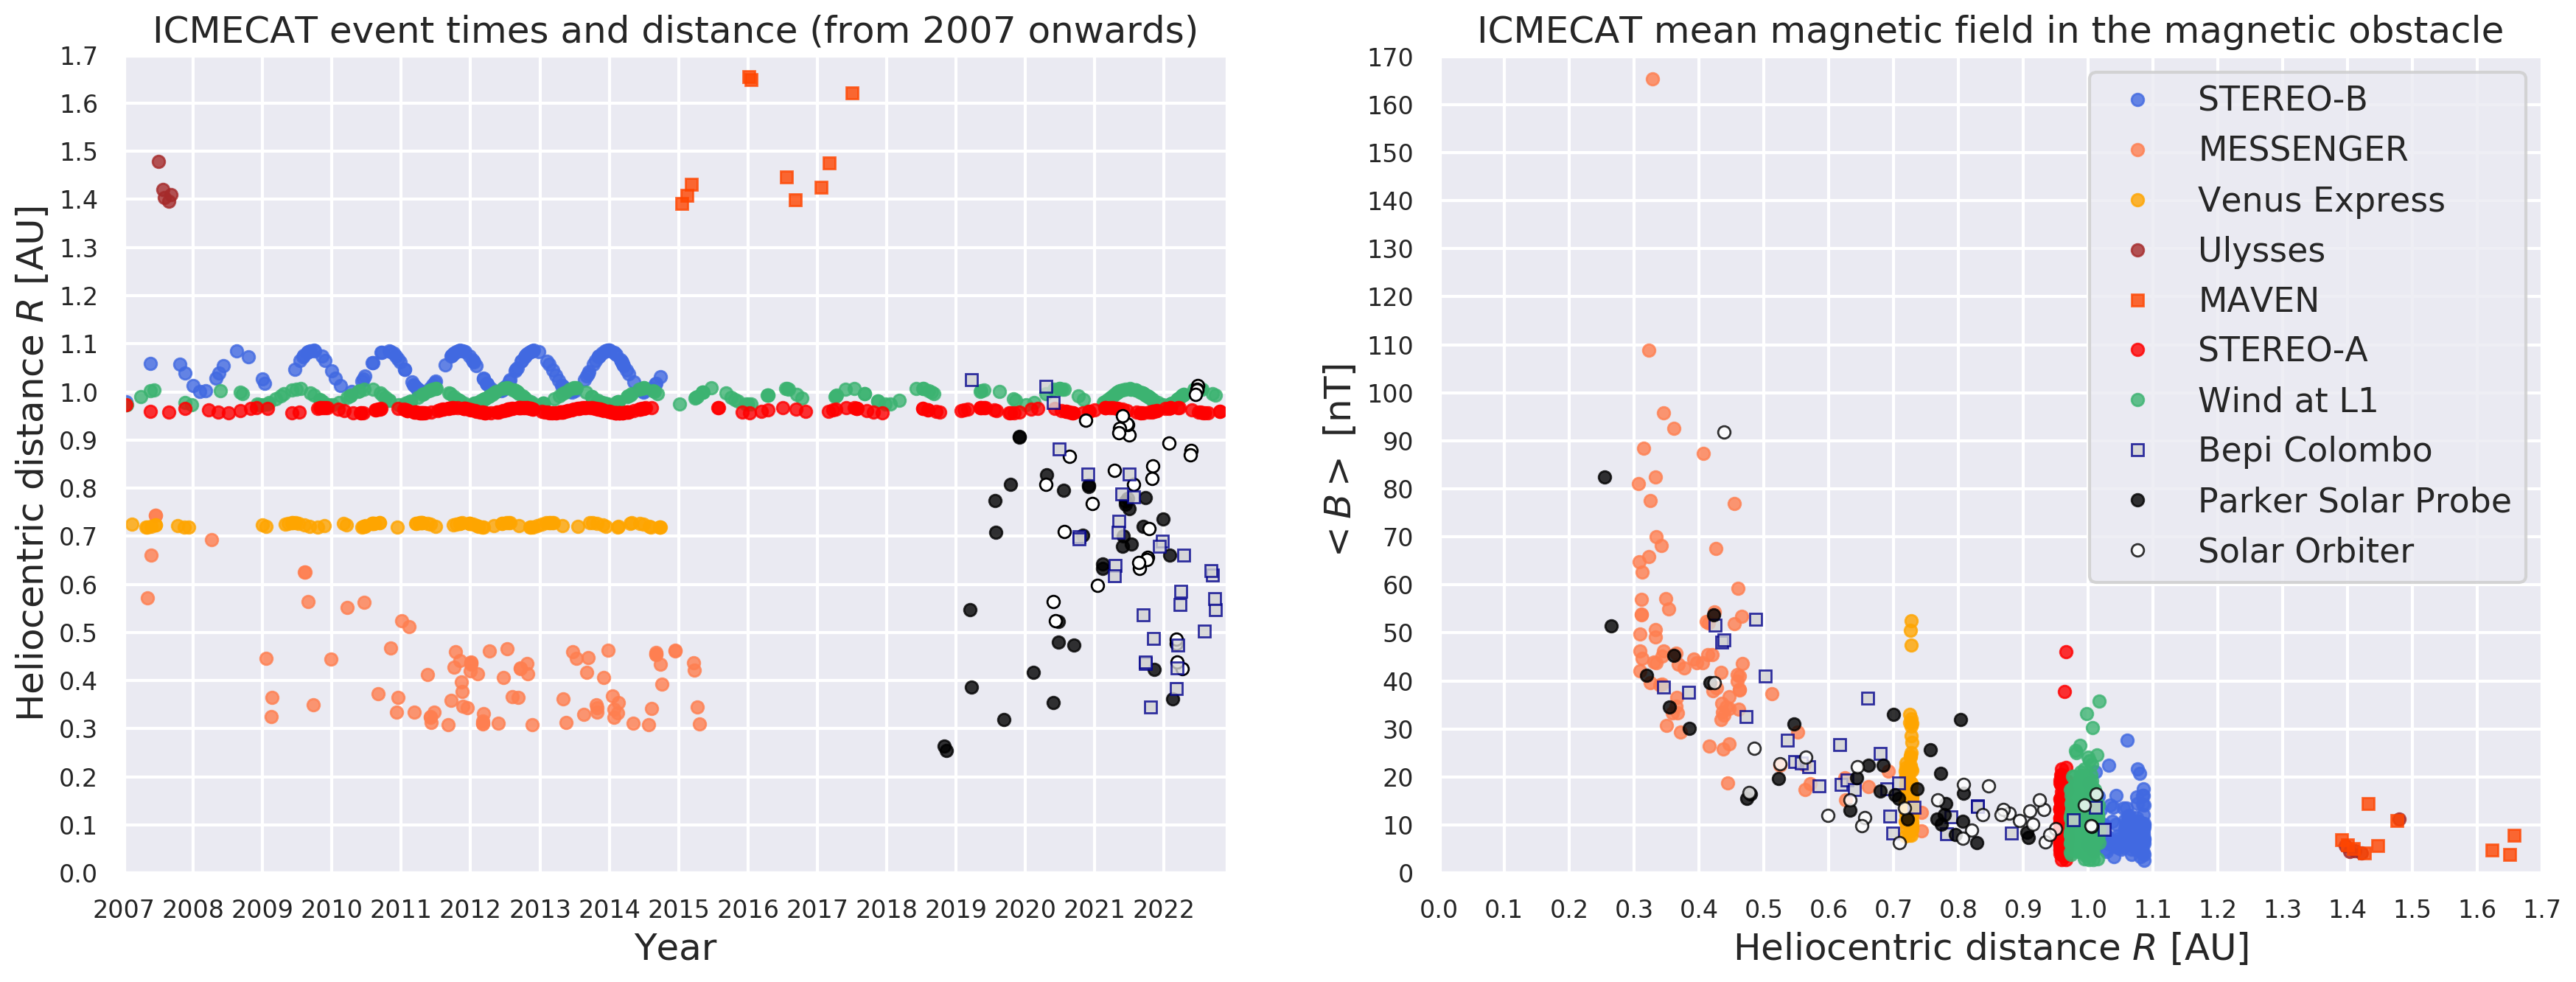

In [43]:
ic=ic_pandas

ic_mo_start_time_num=parse_time(ic.mo_start_time).plot_date

#get indices for each target
imes=np.where(ic.sc_insitu=='MESSENGER')[0]
ivex=np.where(ic.sc_insitu=='VEX')[0]
iwin=np.where(ic.sc_insitu=='Wind')[0]
imav=np.where(ic.sc_insitu=='MAVEN')[0]

ista=np.where(ic.sc_insitu=='STEREO-A')[0]
istb=np.where(ic.sc_insitu=='STEREO-B')[0]
ipsp=np.where(ic.sc_insitu=='PSP')[0]
isol=np.where(ic.sc_insitu=='SolarOrbiter')[0]
ibep=np.where(ic.sc_insitu=='BepiColombo')[0]
iuly=np.where(ic.sc_insitu=='ULYSSES')[0]


sns.set_context("talk")     
sns.set_style('darkgrid')

###############################################################################
fig=plt.figure(3,figsize=(18,7),dpi=200)

#########################################################################
ax1=plt.subplot(121)
plt.title('ICMECAT event times and distance (from 2007 onwards)')

#markersize
ms=6
#alpha
al=0.8

ax1.plot_date(ic_mo_start_time_num[iuly],ic.mo_sc_heliodistance[iuly],'o',c='brown', alpha=al,ms=ms)
ax1.plot_date(ic_mo_start_time_num[imes],ic.mo_sc_heliodistance[imes],'o',c='coral', alpha=al,ms=ms)
ax1.plot_date(ic_mo_start_time_num[ivex],ic.mo_sc_heliodistance[ivex],'o',c='orange', alpha=al,ms=ms)
ax1.plot_date(ic_mo_start_time_num[istb],ic.mo_sc_heliodistance[istb],'o',c='royalblue', alpha=al,ms=ms)
ax1.plot_date(ic_mo_start_time_num[iwin],ic.mo_sc_heliodistance[iwin],'o',c='mediumseagreen', alpha=al,ms=ms)
ax1.plot_date(ic_mo_start_time_num[imav],ic.mo_sc_heliodistance[imav],'s',c='orangered', alpha=al,ms=ms)
ax1.plot_date(ic_mo_start_time_num[ista],ic.mo_sc_heliodistance[ista],'o',c='red', alpha=al,ms=ms)

ax1.plot_date(ic_mo_start_time_num[ipsp],ic.mo_sc_heliodistance[ipsp],'o',c='black', alpha=al,ms=ms)
ax1.plot_date(ic_mo_start_time_num[isol],ic.mo_sc_heliodistance[isol],'o',c='black',markerfacecolor='white', alpha=1.0,ms=ms)
ax1.plot_date(ic_mo_start_time_num[ibep],ic.mo_sc_heliodistance[ibep],'s',c='darkblue',markerfacecolor='lightgrey', alpha=al,ms=ms)



ax1.set_ylabel('Heliocentric distance $R$ [AU]')
ax1.set_xlabel('Year')
ax1.set_ylim([0,1.7])

years = mdates.YearLocator()   # every year
ax1.xaxis.set_major_locator(years)
myformat = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_formatter(myformat)

ax1.tick_params(axis="x", labelsize=12)
ax1.tick_params(axis="y", labelsize=12)

ax1.set_xlim([datetime.datetime(2007,1,1),datetime.datetime.utcnow()])


ax1.set_yticks(np.arange(0,2,0.1))
ax1.set_ylim([0,1.7])



##############################################################################
ax3=plt.subplot(122)
plt.title('ICMECAT mean magnetic field in the magnetic obstacle')
ax3.set_xlabel('Heliocentric distance $R$ [AU]')
ax3.set_ylabel('$<B>$ [nT]')



ax3.plot(ic.mo_sc_heliodistance[istb],ic.mo_bmean[istb],'o',c='royalblue', alpha=al,ms=ms, label='STEREO-B')
ax3.plot(ic.mo_sc_heliodistance[imes],ic.mo_bmean[imes],'o',c='coral', alpha=al,ms=ms,label='MESSENGER')
ax3.plot(ic.mo_sc_heliodistance[ivex],ic.mo_bmean[ivex],'o',c='orange', alpha=al,ms=ms,label='Venus Express')
ax3.plot(ic.mo_sc_heliodistance[iuly],ic.mo_bmean[iuly],'o',c='brown', alpha=al,ms=ms, label='Ulysses')
ax3.plot(ic.mo_sc_heliodistance[imav],ic.mo_bmean[imav],'s',c='orangered', alpha=al,ms=ms, label='MAVEN')



ax3.plot(ic.mo_sc_heliodistance[ista],ic.mo_bmean[ista],'o',c='red', alpha=al,ms=ms, label='STEREO-A')
ax3.plot(ic.mo_sc_heliodistance[iwin],ic.mo_bmean[iwin],'o',c='mediumseagreen', alpha=al,ms=ms,label='Wind at L1')
ax3.plot(ic.mo_sc_heliodistance[ibep],ic.mo_bmean[ibep],'s',c='darkblue',markerfacecolor='lightgrey', alpha=al,ms=ms,label='Bepi Colombo')
ax3.plot(ic.mo_sc_heliodistance[ipsp],ic.mo_bmean[ipsp],'o',c='black', alpha=al,ms=ms, label='Parker Solar Probe',zorder=3)
ax3.plot(ic.mo_sc_heliodistance[isol],ic.mo_bmean[isol],'o',c='black', markerfacecolor='white',alpha=al,ms=ms, label='Solar Orbiter',zorder=3)


ax3.legend(loc=1)

ax3.set_xticks(np.arange(0,2,0.1))
ax3.tick_params(axis="x", labelsize=12)

ax3.set_yticks(np.arange(0,180,10))
ax3.tick_params(axis="y", labelsize=12)

ax3.set_xlim([0,1.7])
ax3.set_ylim([0,np.max(ic.mo_bmean)+5])



plt.tight_layout()
plt.savefig('icmecat/icmecat_overview.png', dpi=150,bbox_inches='tight')

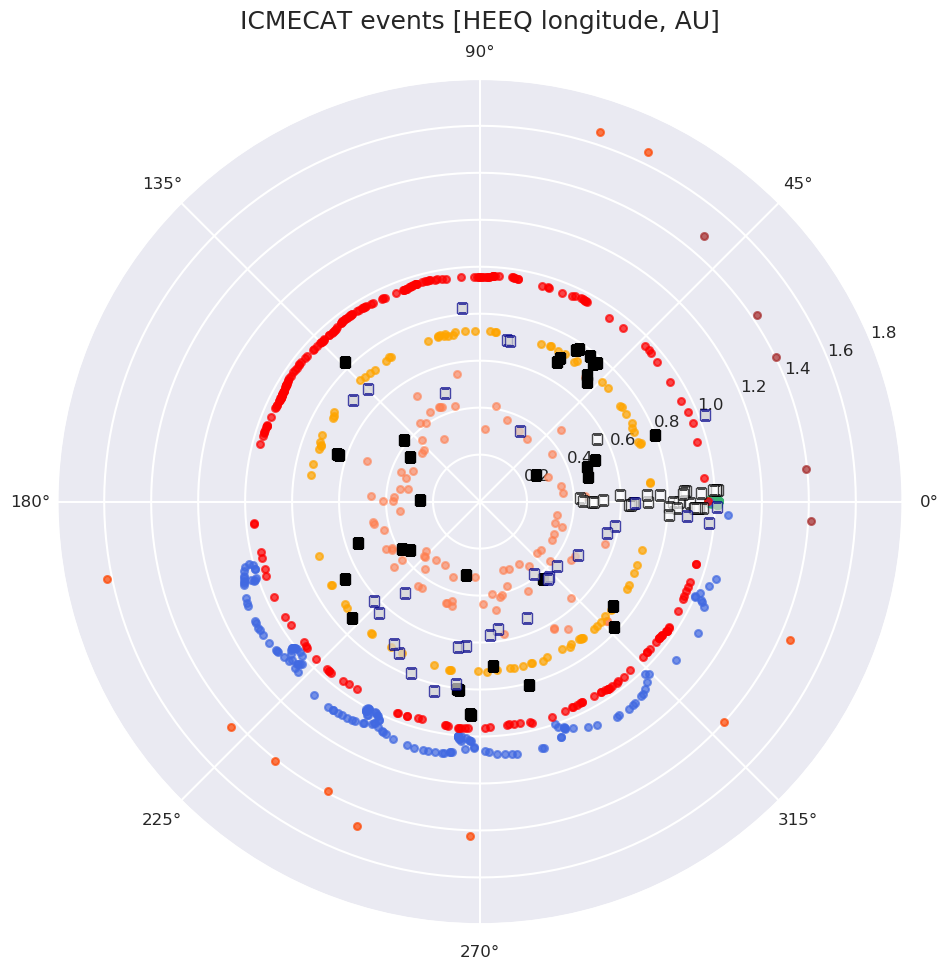

In [44]:
#markersize
ms=25
ms2=7
#alpha
al=0.7

sns.set_context("talk")     
sns.set_style('darkgrid')

###############################################################################
fig=plt.figure(3,figsize=(10,10),dpi=100)

#########################################################################
ax2=plt.subplot(111,projection='polar')

plt.title('ICMECAT events [HEEQ longitude, AU]')

ax2.scatter(np.radians(ic.mo_sc_long_heeq[iuly]),ic.mo_sc_heliodistance[iuly],s=ms,c='brown', alpha=al)
ax2.scatter(np.radians(ic.mo_sc_long_heeq[imes]),ic.mo_sc_heliodistance	[imes],s=ms,c='coral', alpha=0.6)
ax2.scatter(np.radians(ic.mo_sc_long_heeq[ivex]),ic.mo_sc_heliodistance	[ivex],s=ms,c='orange', alpha=al)
ax2.scatter(np.radians(ic.mo_sc_long_heeq[iwin]),ic.mo_sc_heliodistance	[iwin],s=ms,c='mediumseagreen', alpha=al)
ax2.scatter(np.radians(ic.mo_sc_long_heeq[istb]),ic.mo_sc_heliodistance[istb],s=ms,c='royalblue', alpha=al)

ax2.scatter(np.radians(ic.mo_sc_long_heeq[imav]),ic.mo_sc_heliodistance	[imav],s=ms,c='orangered', alpha=al)
ax2.scatter(np.radians(ic.mo_sc_long_heeq[ista]),ic.mo_sc_heliodistance[ista],s=ms,c='red', alpha=al)

ax2.plot(np.radians(ic.mo_sc_long_heeq[ipsp]),ic.mo_sc_heliodistance[ipsp],'s',markersize=ms2, c='black', alpha=1.0)
ax2.plot(np.radians(ic.mo_sc_long_heeq[isol]),ic.mo_sc_heliodistance[isol],'s',markersize=ms2, c='black',markerfacecolor='white', alpha=al)
ax2.plot(np.radians(ic.mo_sc_long_heeq[ibep]),ic.mo_sc_heliodistance[ibep],'s',markersize=ms2, c='darkblue',markerfacecolor='lightgrey', alpha=al)



ax2.set_ylim([0,1.8])
ax2.tick_params(labelsize=12,zorder=3)


plt.tight_layout()
plt.savefig('icmecat/icmecat_overview2.png', dpi=150,bbox_inches='tight')

## Parameter distribution plots

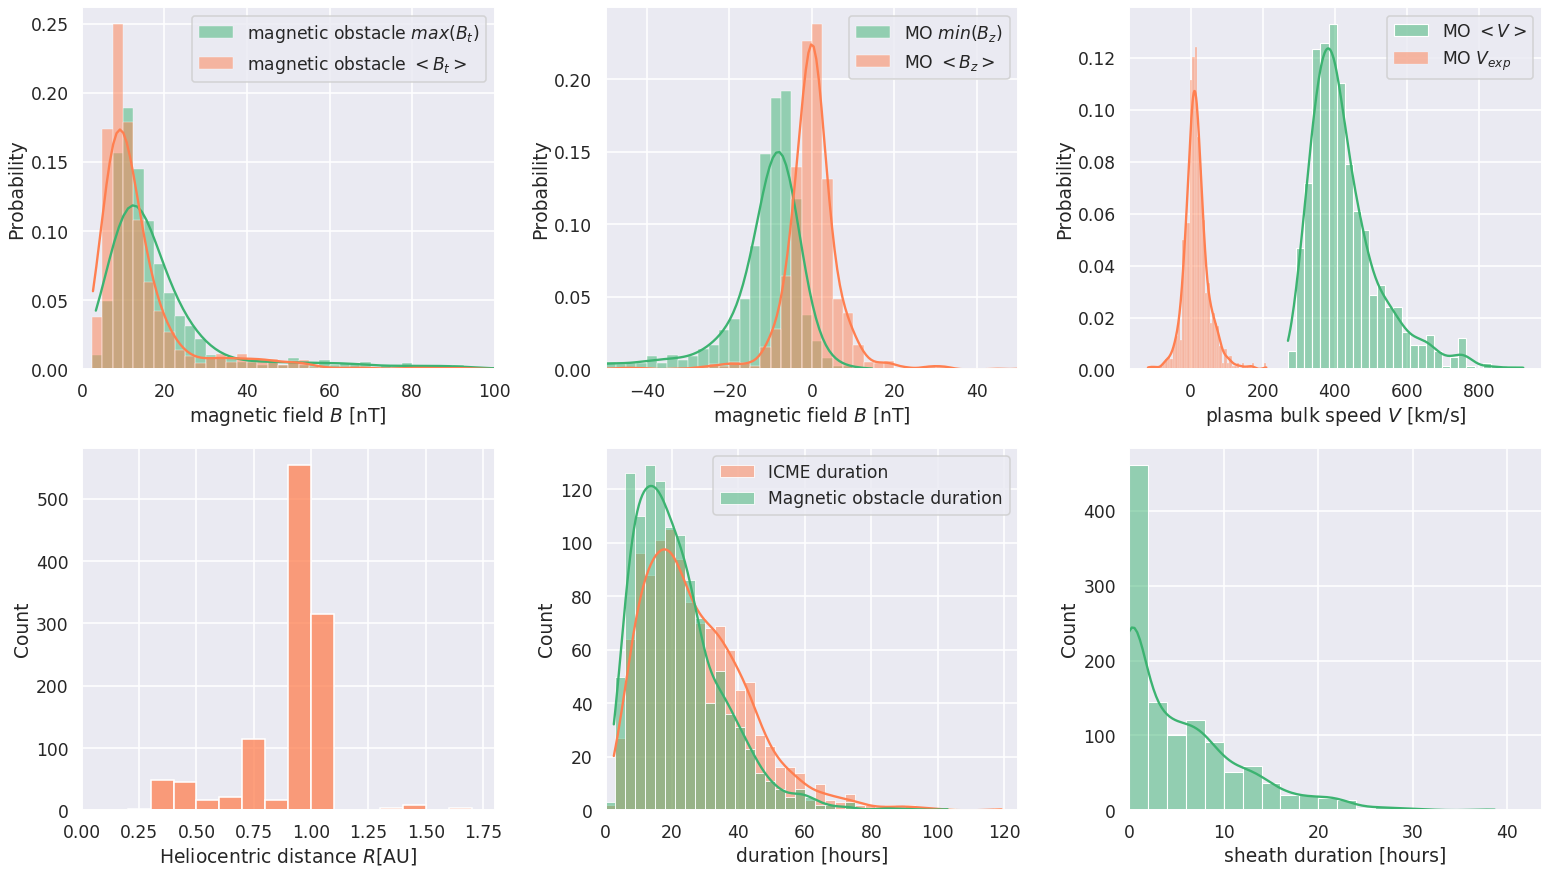

In [30]:
#make distribution plots
plt.figure(10,figsize=(21,12),dpi=75)



ax2=plt.subplot(231)
sns.histplot(ic.mo_bmax, label='magnetic obstacle $max(B_t)$',color='mediumseagreen',kde=True, bins=np.arange(0,100,2.5), stat='probability')
sns.histplot(ic.mo_bmean, label='magnetic obstacle $<B_t>$',color='coral',alpha=0.5,kde=True, bins=np.arange(0,100,2.5),stat='probability')
plt.legend(loc=1)
ax2.set_xlabel('magnetic field $B$ [nT]')
ax2.set_xlim(0,100)


ax3=plt.subplot(232)
sns.histplot(ic.mo_bzmin,label='MO $min(B_z)$',color='mediumseagreen',kde=True, bins=np.arange(-50,50,2.5),stat='probability')
sns.histplot(ic.mo_bzmean,label='MO $<B_z>$',color='coral',alpha=0.5,kde=True, bins=np.arange(-50,50,2.5),stat='probability')
plt.legend(loc=1)
ax3.set_xlabel('magnetic field $B$ [nT]')
plt.xlim(-50,50)


ax4=plt.subplot(233)
sns.histplot(ic.mo_speed_mean,label='MO $<V>$',color='mediumseagreen',kde=True,stat='probability')
sns.histplot(ic.mo_expansion_speed,label='MO $V_{exp}$',color='coral',alpha=0.5,kde=True,stat='probability')
plt.legend(loc=1)
ax4.set_xlabel('plasma bulk speed $V$ [km/s]')


ax5=plt.subplot(234)
sns.histplot(ic.mo_sc_heliodistance,color='coral',bins=np.arange(0,1.8,0.1))
ax5.set_xlim(0,1.8)
ax5.set_xlabel('Heliocentric distance $R$[AU]')


ax6=plt.subplot(235)
sns.histplot(ic.icme_duration,color='coral',alpha=0.5,bins=np.arange(0,np.max(ic.icme_duration)+5,3),kde=True,stat='count',label='ICME duration')
sns.histplot(ic.mo_duration,color='mediumseagreen',bins=np.arange(0,np.max(ic.mo_duration)+5,3),kde=True, stat='count',label='Magnetic obstacle duration')
ax6.set_xlabel('duration [hours]')
ax6.set_xlim(0,np.max(ic.icme_duration)+5)
plt.legend(loc=1)

ax7=plt.subplot(236)
#sns.histplot(ic.mo_duration,color='coral',bins=np.arange(0,np.max(ic.mo_duration)+5,3),kde=True, stat='count')
#sheath duration
sns.histplot(ic.icme_duration-ic.mo_duration,color='mediumseagreen',bins=np.arange(0,np.max(ic.icme_duration-ic.mo_duration)+5,2),kde=True, stat='count')
ax7.set_xlabel('sheath duration [hours]')
ax7.set_xlim(0,np.max(ic.icme_duration-ic.mo_duration)+5)



plt.tight_layout()
plt.savefig('icmecat/icmecat_overview3.png', dpi=150,bbox_inches='tight')

In [31]:
#read JUNO catalog from Emma Davies


junocat='data/HELIO4CAST_ICMECAT_juno_davies_chris.csv'

jc=pd.read_csv(junocat)

jc

#convert all times to datetime objects
#for i in np.arange(0,ic.shape[0]):    
        #remove leading and ending blank spaces if any and write datetime object into dataframe
#        ic.at[i,'icme_start_time']= parse_time(str(ic.icme_start_time[i]).strip()).datetime 
#        ic.at[i,'mo_start_time']=parse_time(str(ic.mo_start_time[i]).strip()).datetime
#        ic.at[i,'mo_end_time']=parse_time(str(ic.mo_end_time[i]).strip()).datetime
       



,icmecat_id;sc_insitu;icme_start_time;mo_start_time;mo_end_time;;
0,ICME_JUNO_DAVIES_20110909_01;Juno;2011-09-09T1...
1,ICME_JUNO_DAVIES_20110917_01;Juno;2011-09-17T0...
2,ICME_JUNO_DAVIES_20110927_01;Juno;2011-09-27T0...
3,ICME_JUNO_DAVIES_20111005_01;Juno;2011-10-05T2...
4,ICME_JUNO_DAVIES_20111025_01;Juno;2011-10-25T1...
5,ICME_JUNO_DAVIES_20111101_01;Juno;2011-11-01T0...
6,ICME_JUNO_DAVIES_20111102_01;Juno;2011-11-02T1...
7,ICME_JUNO_DAVIES_20111103_01;Juno;2011-11-03T0...
8,ICME_JUNO_DAVIES_20111106_01;Juno;2011-11-06T0...
9,ICME_JUNO_DAVIES_20111109_01;Juno;2011-11-09T0...
